### NOW EXPERIMENTING:
Pinet: 
* regularized by pseudo labeled data, but it also have some lagecy label which seems in the eraly stage, seems wrong
* change core model

### Done:
* try pure training dataset, should be same to normal train
* noise and rotation cause huge performance decrease.....
* randomize in first batch otherwise loss seems a bit strange.
* add some random noice
* custom data generate to update test temperal mask every n epoch
* change unsupervise loss weight on the fly
* used full model (without dropout) for validation and prediction
* close augmentation: noise, rotation, no temperal predict, no temperal loss
* ramp-up function is also important as early psuedo label is very wrong, reduced temperal loss in early stage, otherwise network will learn wrong pattern from early stage psuedo label
* train on train then test order, insure frist part of training has all label, which won't confuse network, solution: use a ration to adjust how much label vs unlabel loss will go into total loss (unlabled size / batch size) * w
* loss is toooooooo high without any reason: its cause by test data, when update weight with test data which don't have label, it cause network confuse because those update don't have gradient, (are based on other's graident)...
* sample data(train + test) from db, split train data into train val data
* apply test data mask if its none (no temperal mask)
* basic augmentation twice for pinet
* custom pi net loss function
* move prediction into here as it used custom function

### work: 
* image data augmentation, flip, crop,
* resnet with high dropout, (as resnet so easy overfitting, and not enough data)
* 2d spatial dropout
* dice loss, faster converge, but doesn't help improve score....

### not work:
* deeper, shellower
* Clahe
* pure dice loss, it will give binary solution, rather than probability
* dropout=0.6, overfitting, Val=0.8, LB=0.77

### idea:
* augmentation: rotation, affine transform, Elastic deformations
* reduce dropout, as always under fitting
* smaller batch size
* CRF
* inception block


In [1]:
import numpy as np
import pandas as pd
import time, sys, json, os, io, cv2, base64
from io import BytesIO
from subprocess import check_output
from pprint import pprint as pp
import pymongo
from pymongo import MongoClient
import hashlib
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
from imageio import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from random import randint
from skimage import exposure
from skimage.color import gray2rgb
from skimage.color import rgb2gray
from skimage import transform
from skimage import util
from tqdm import tqdm_notebook
import skimage as sk
import gc
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

os.environ["CUDA_VISIBLE_DEVICES"]="0"

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

import keras
from keras.preprocessing.image import load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout, BatchNormalization
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.models import Model, load_model
from keras.layers import Input, UpSampling2D, Concatenate, SpatialDropout2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
from keras.backend.tensorflow_backend import set_session
from keras.layers.merge import add
from keras import regularizers
from keras.regularizers import l2
from keras.losses import binary_crossentropy
from keras.activations import softmax
from keras.backend import tensorflow_backend, common
from keras.callbacks import LambdaCallback, Callback
import tensorflow as tf

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
path_train = '../data/train/'
path_test = '../data/test/'
train_ids = next(os.walk(path_train))[2]
test_ids = next(os.walk(path_test))[2]
depths_df = pd.read_csv("../data/depths.csv", index_col="id")
train_df = pd.read_csv("../data/train.csv", index_col="id")

In [3]:
def _connect_mongo(host, port, username, password, db):
    """ A util for making a connection to mongo """
    if username and password:
        mongo_uri = 'mongodb://%s:%s@%s:%s/%s' % (username, password, host, port, db)
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)
    return conn[db]

def insert_data(data, db, collection, check_id='id', host='localhost', port=27017, username=None, password=None, no_id=True):
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)
    
    duplicate_result = db[collection].find(
       {check_id: data[check_id]})
    
    print('duplicate count' + str(duplicate_result.count()))
    if duplicate_result.count() == 0:
        db[collection].insert_one(data)

def set_data(db, collection, search, set_query, host='localhost', port=27017, username=None, password=None, no_id=True):
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)
    db[collection].update(
        search,
        { '$set': set_query }
    )
        
def read_mongo(db, collection, query={}, host='localhost', port=27017, username=None, password=None, no_id=True):
    """ Read from Mongo and Store into DataFrame """
    # Connect to MongoDB
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)

    # Make a query to the specific DB and Collection
    cursor = db[collection].find(query)

    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor))

    # Delete the _id
    if no_id:
        del df['_id']

    return df

def sample_mongo(db, collection, query={}, host='localhost', port=27017, username=None, password=None, no_id=True, num_sample=1000):
    """ Read from Mongo and Store into DataFrame """
    # Connect to MongoDB
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)

    # Make a query to the specific DB and Collection
    cursor = db[collection].aggregate([{ "$sample": { "size": num_sample }}])

    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor))

    # Delete the _id
    if no_id:
        del df['_id']

    return df

# Put all dataset into DF frist, hold in memory

In [4]:
img_size_ori = 101
img_size_target = 128

def read_resize_img(x, scale,mask=False):
    img_byte = io.BytesIO(base64.b64decode(x))
    img_np = np.array(imread(img_byte, as_gray=True))/scale
    img_np = resize(img_np,(img_size_target,img_size_target), mode='constant', preserve_range=True)
    if mask:
        img_np[img_np>0] = 1
    return img_np

train_df = read_mongo('dataset', 'tgs_salt', {"$and": [{"img_mask_base64":{"$ne":None}}]})

############# sample or all test data from db #############
# test_df = read_mongo('dataset', 'tgs_salt', {"$and": [{"img_mask_base64":{"$eq":None}}]})
test_df = sample_mongo('dataset', 'tgs_salt', {"$and": [{"img_mask_base64":{"$eq":None}}]}, num_sample=3600)

train_df['img'] = train_df['img_base64'].apply(lambda x: read_resize_img(x, 256.0))
train_df['img_mask'] = train_df['img_mask_base64'].apply(lambda x: read_resize_img(x, 65535.0, mask=True))
train_df['img_temperal_mask'] = train_df['img'].apply(lambda x: -1*np.ones((img_size_target,img_size_target)))
test_df['img'] = test_df['img_base64'].apply(lambda x: read_resize_img(x, 256.0))
test_df['img_mask'] = test_df['img'].apply(lambda x: -1*np.ones((img_size_target,img_size_target)))
test_df['img_temperal_mask'] = test_df['img'].apply(lambda x: -1*np.ones((img_size_target,img_size_target)))

train_df = train_df.drop('img_base64', axis=1)
train_df = train_df.drop('img_mask_base64', axis=1)
train_df = train_df.drop('ASM', axis=1)
train_df = train_df.drop('contrast', axis=1)
train_df = train_df.drop('correlation', axis=1)
train_df = train_df.drop('dissimilarity', axis=1)
train_df = train_df.drop('energy', axis=1)
train_df = train_df.drop('entropy', axis=1)
train_df = train_df.drop('homogeneity', axis=1)
train_df = train_df.drop('coverage', axis=1)
train_df = train_df.drop('coverage_class', axis=1)
test_df = test_df.drop('img_base64', axis=1)
# test_df = test_df.drop('img_mask_base64', axis=1)
# test_df = test_df.drop('ASM', axis=1)
# test_df = test_df.drop('contrast', axis=1)
# test_df = test_df.drop('correlation', axis=1)
# test_df = test_df.drop('dissimilarity', axis=1)
# test_df = test_df.drop('energy', axis=1)
# test_df = test_df.drop('entropy', axis=1)
# test_df = test_df.drop('homogeneity', axis=1)
# test_df = test_df.drop('coverage', axis=1)
# test_df = test_df.drop('coverage_class', axis=1)

train_df, val_df = train_test_split(train_df, test_size=0.1)

############# use test + train or only train data #############
train_test_df = pd.concat([train_df, test_df], axis=0, ignore_index=True, sort=False).sample(frac=1).reset_index(drop=True)
# train_test_df = train_df.copy()

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)
print(train_test_df.shape)

(3600, 7)
(400, 7)
(18000, 6)
(21600, 7)


In [5]:
# train_test_df.head(-1)

# Data Preprcessing function: sample, augment, to np_array

In [6]:
def noisy(noise_typ,image):
   if noise_typ == "gauss":
      row,col,ch= image.shape
      mean = 0
      var = 0.0005
      sigma = var**0.5
      gauss = np.random.normal(mean,sigma,(row,col,ch))
      gauss = gauss.reshape(row,col,ch)
      noisy = image + gauss
      return noisy
   elif noise_typ == "s&p":
      row,col,ch = image.shape
      s_vs_p = 0.5
      amount = 0.01
      out = np.copy(image)
      # Salt mode
      num_salt = np.ceil(amount * image.size * s_vs_p)
      coords = [np.random.randint(0, i, int(num_salt))
              for i in image.shape]
      out[coords] = 1

      # Pepper mode
      num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
      coords = [np.random.randint(0, i, int(num_pepper))
              for i in image.shape]
      out[coords] = 0
      return out
   elif noise_typ == "poisson":
      vals = len(np.unique(image))
      vals = 2 ** np.ceil(np.log2(vals))
      noisy = np.random.poisson(image * vals) / float(vals)
      return noisy
   elif noise_typ =="speckle":
      scale = 0.05
      row,col,ch = image.shape
      gauss = np.random.randn(row,col,ch)
      gauss = gauss.reshape(row,col,ch)        
      noisy = image + image * gauss * scale
      return noisy
   elif noise_typ == 'None':
      return image

def _img_augmentation(_df, if_augment=True):
    def random_crop_resize(x, crop, flip, degree, noise_type='None'):
        # return x if all pixel is -1
        if np.mean(x) == -1:
            return x
        
        x = np.fliplr(x) if flip else x
        
        ######### noise, rotate decrease the performance a lot... ###########
#         x = np.squeeze(noisy(noise_type, np.expand_dims(x, axis=3)))
#         x = sk.transform.rotate(x, degree)
        x = x[crop[0]:-crop[1],crop[2]:-crop[3]]
        x = resize(x,(img_size_target,img_size_target), mode='constant', preserve_range=True)
        return x

    def img_augment(df):
        augment_df = pd.DataFrame()
        for index, row in df.iterrows():
            # np.random.seed(0)
            crop = np.random.randint(low=1, high=30, size=4) if if_augment else np.array([0, 1, 0, 1])
            flip = np.random.choice([True, False]) if if_augment else False
            degree = np.random.uniform(-10, 10) if if_augment else 0
            noise_type = np.random.choice(['gauss', 'poisson', 's&p', 'speckle', 'None']) if if_augment else 'None'
            
            aug_img = random_crop_resize(row['img'], crop, flip, degree, noise_type)
            aug_img_mask = random_crop_resize(row['img_mask'], crop, flip, degree)
            aug_img_temperal_mask = random_crop_resize(row['img_temperal_mask'], crop, flip, degree)

            
            augment_df = augment_df.append(
                {
                    'depth': row['depth'],
                    'img_id': row['img_id']+'_augment',
                    'aug_img': aug_img,
                    'aug_img_mask': aug_img_mask,
                    'aug_img_temperal_mask': aug_img_temperal_mask,
                }, ignore_index=True
            )
        return augment_df
    
    _augment_df = img_augment(_df)
    
    return _augment_df

def _convert_to_np_array(_augment_df):
    X_np = np.expand_dims(np.stack((np.asarray(_augment_df['aug_img'].values.tolist()))),axis=3)
    y_np = np.expand_dims(np.asarray(_augment_df['aug_img_mask'].values.tolist()),axis=3)
    y_temp_np = np.expand_dims(np.asarray(_augment_df['aug_img_temperal_mask'].values.tolist()),axis=3)
    y_np = np.concatenate((y_np,y_temp_np),axis=3)
    
    return X_np, y_np

def calculate_temperal_mask(epoch):
    global model_train, train_df, test_df, graph_train
    with graph_train.as_default():
        X_train = np.expand_dims(np.stack((np.asarray(train_df['img'].values.tolist()))),axis=3)
        predict_train = model_train.predict(X_train,batch_size=64, verbose=1)
        predict_train = np.squeeze(predict_train)
        
        X_test = np.expand_dims(np.stack((np.asarray(test_df['img'].values.tolist()))),axis=3)
        predict_test = model_train.predict(X_test,batch_size=64, verbose=1)
        predict_test = np.squeeze(predict_test)
    
    idx = 0;
    alpha = 0.5
#     temperal_mask_ramp_up = 1/(1-(alpha**(epoch+1)))
    for index, row in tqdm_notebook(train_df.iterrows(),total=len(train_df.index)):
        img_temperal_mask = row['img_temperal_mask']
        predict = predict_train[idx]; idx+=1;
        if(np.mean(img_temperal_mask) < 0):
            train_df.at[index,'img_temperal_mask'] = predict
        else:
            train_df.at[index,'img_temperal_mask'] = (img_temperal_mask*alpha + predict*(1-alpha))
            
    for index, row in tqdm_notebook(test_df.iterrows(),total=len(test_df.index)):
        img_temperal_mask = row['img_temperal_mask']
        predict = predict_test[index]
        if(np.mean(img_temperal_mask) < 0):
            test_df.at[index,'img_temperal_mask'] = predict
        else:
            test_df.at[index,'img_temperal_mask'] = (img_temperal_mask*alpha + predict*(1-alpha))
    
    train_test_df = pd.concat([train_df, test_df], axis=0, ignore_index=True, sort=False).sample(frac=1).reset_index(drop=True)

    return train_test_df

# plot some augmented image

In [7]:
# sample_train_df = train_df.sample(50)
# train_augment_df = _img_augmentation(sample_train_df)

# %%time
# sample_train_df, sample_val_df, sample_test_df = sample_df(train_df, val_df, test_df)
# train_augment_df, val_augment_df, test_augment_df = img_augmentation(sample_train_df, sample_val_df, sample_test_df)
# X_train, y_train, X_valid, y_valid = convert_to_np_array(train_augment_df, val_augment_df, test_augment_df)


In [8]:
# test_augment_df.head(1)
# train_augment_df.head(10)

In [9]:
# base_idx = 0
# max_images = 16
# grid_width = 4
# grid_height = int(max_images / grid_width)
# fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))
# row = 0; col = 0;
# for i, idx in enumerate(train_augment_df.index[base_idx:base_idx+int(max_images)]):
#     img = train_augment_df.loc[idx].aug_img
#     mask = train_augment_df.loc[idx].aug_img_mask
    
#     ax = axs[row, col];
#     ax.imshow(img, cmap="seismic")
# #     ax.imshow(img, cmap="gray")
#     ax.imshow(mask, alpha=0.8, cmap="Reds"); col+=1;
#     ax.set_yticklabels([]); ax.set_xticklabels([]);
    
#     if col >= grid_width:
#         col=0; row+=1;


# Custom loss function

In [11]:
from debug import _debug_func

# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

# MSE between current and temporal outputs
def temperal_mse_loss(y_true, y_pred):

    def mse_loss(y_pred, y_temperal, temperal_size):
        # generate filter using y_temperal
        temperal_filter = tf.stop_gradient(tf.cast(tf.not_equal(y_temperal, -1), tf.float32))

        # filter out MSE if temperal = -1
        quad_diff = K.sum((temperal_filter*y_pred - temperal_filter*y_temperal) ** 2) / (temperal_size*128*128+1e-15)

        return quad_diff

    y_temperal = tf.slice(y_true, [0, 0, 0, 1], [-1, -1, -1, 1])

    # count temperal size which has value (not -1)
    temperal_size=tf.stop_gradient(tf.reduce_sum(tf.cast(tf.not_equal(tf.reduce_min(y_temperal, [1,2,3]), -1), tf.float32)))

    quad_diff = tf.cond(temperal_size > 0, lambda: mse_loss(y_pred, y_temperal, temperal_size), lambda: 0.0)

    return quad_diff

def masked_crossentropy(y_true, y_pred):
    y_mask = tf.slice(y_true, [0, 0, 0, 0], [-1, -1, -1, 1])
#     y_mask = _debug_func((y_mask),"y_mask")

    # count mask size
    mask_size=tf.stop_gradient(tf.reduce_sum(tf.cast(tf.not_equal(tf.reduce_min(y_mask, [1,2,3]), -1), tf.float32)))

    # generate mask filter as test doesn't have mask (-1)
    mask_filter = tf.stop_gradient(tf.cast(tf.not_equal(y_mask, -1), tf.float32))

    y_mask = y_mask*mask_filter
    y_pred = y_pred*mask_filter
    
    bce_loss_ = tf.cond(mask_size > 0, lambda: (K.sum(binary_crossentropy(y_mask, y_pred))/(mask_size*128*128+1e-15)), lambda: 0.0)    
    dice_loss_ = dice_loss(y_mask, y_pred)
    
    bce_dice_loss_ = bce_loss_ + dice_loss_

    return bce_dice_loss_

def mask_mean_iou(y_true, y_pred):
    y_mask = tf.slice(y_true, [0, 0, 0, 0], [-1, -1, -1, 1])
    mask_filter = tf.cast(tf.not_equal(y_mask, -1), tf.float32)
    mask_mean_iou = mean_iou(mask_filter*y_mask, mask_filter*y_pred)
    return mask_mean_iou

def temperal_mean_iou(y_true, y_pred):
    y_temperal = tf.slice(y_true, [0, 0, 0, 1], [-1, -1, -1, 1])
    temperal_filter = tf.cast(tf.not_equal(y_temperal, -1), tf.float32)
    temperal_mean_iou = mean_iou(temperal_filter*(tf.cast(tf.greater(y_temperal,0.5), tf.float32)), temperal_filter*y_pred)
    return temperal_mean_iou

class Temperal_Callback(Callback):
    def __init__(self, delay_temperal=0, ramp_up_period=50):
        self.ramp_up = 0
        self.ramp_up_period = ramp_up_period
        self.w = 1.0 / self.ramp_up_period
        self.delay_temperal = delay_temperal
        
    # customize your behavior
    def on_epoch_end(self, epoch, logs={}):
        if epoch-self.delay_temperal < 0:
            self.ramp_up = 0
        elif epoch-self.delay_temperal < self.ramp_up_period:
            self.ramp_up = np.exp(-5*((1-((epoch-self.delay_temperal)/self.ramp_up_period)))**2)
        else:
            self.ramp_up = 1
        logger.info("epoch %s, ramp_up = %s" % (epoch, self.ramp_up))

    def temporal_loss(self, y_true, y_pred):
        sup_loss = masked_crossentropy(y_true, y_pred)
        unsup_loss = temperal_mse_loss(y_true, y_pred)

        batch_size = tf.stop_gradient(tf.to_float(tf.shape(y_pred)[0]))
        y_mask = tf.stop_gradient(tf.slice(y_true, [0, 0, 0, 0], [-1, -1, -1, 1]))
        mask_size = tf.stop_gradient(tf.reduce_sum(tf.cast(tf.not_equal(tf.reduce_min(y_mask, [1,2,3]), -1), tf.float32)))
        
        w = self.w * (1.0-(mask_size/batch_size)) * self.ramp_up
#         sup_loss = _debug_func((sup_loss),"sup_loss")
#         unsup_loss = _debug_func((unsup_loss),"unsup_loss")
        
        ######## use sup+unsup or only sup loss########
#         return sup_loss
        return sup_loss + w * unsup_loss

# DataGenerator

In [16]:
class DataGenerator(keras.utils.Sequence):
    #class static variable
    global model_train
    _val_df = None
    _train_test_df = None
    _X_train = None
    _y_train = None
    _X_valid = None
    _y_valid = None
    
    'Generates data for Keras'
    def __init__(self, train_test_df, val_df, 
                 batch_size=32, shuffle=True, training=True, temperal_every_epoch=1, delay_temperal=0):
        self.training = training
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.epoch = 0
        self.val_size = val_df.shape[0]
        self.train_test_size = train_test_df.shape[0]
        self.temperal_every_epoch = temperal_every_epoch
        self.delay_temperal = delay_temperal
        
        print(f'val_size = {self.val_size}, \
              train_test_size = {self.train_test_size}, \
              ')
        
        'Initial static variable'
        if self.training:
            DataGenerator._val_df = val_df
            DataGenerator._train_test_df = train_test_df

    def __len__(self):
        'Denotes the number of batches per epoch'
        if self.training:
            print('train lenght')
            print(int(np.floor((self.train_test_size) / self.batch_size)))
            return int(np.floor((self.train_test_size) / self.batch_size))
        else:
            print('val lenght')
            print(int(np.floor(self.val_size / self.batch_size)))
            return int(np.floor(self.val_size / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        'index: indicate which batch in a epoch, (first, second or third batch)'
        # Generate indexes of the batch
        if self.training:            
            batch_train_df = DataGenerator._train_test_df.iloc[index*self.batch_size:(index+1)*self.batch_size]
            train_augment_df = _img_augmentation(batch_train_df)
            X_train_np, y_train_np = _convert_to_np_array(train_augment_df)
            
            return X_train_np, y_train_np
        else:
            batch_val_df = DataGenerator._val_df.iloc[index*self.batch_size:(index+1)*self.batch_size]
            val_augment_df = _img_augmentation(batch_val_df, if_augment=False)
            X_val_np, y_val_np = _convert_to_np_array(val_augment_df)
            
            del batch_val_df, val_augment_df
            
            return X_val_np, y_val_np

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        print(f', epoch={self.epoch}')
        if self.epoch % self.temperal_every_epoch == 0 and self.training and self.epoch >= self.delay_temperal:
            new_train_test_df = calculate_temperal_mask(self.epoch)
            DataGenerator._train_test_df = new_train_test_df
        self.epoch += 1

# Build Unet + Resnet

In [17]:
# tensorflow session setting
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
set_session(tf.Session(config=tf_config))

def conv_block(m, dim, acti, bn, res, do=0, training=None):
    n = Conv2D(dim, 3, activation=acti, padding='same')(m)
    n = BatchNormalization()(n) if bn else n
    n = SpatialDropout2D(do/2.0)(n, training=training) if do else n
    n = Conv2D(dim, 3, activation=acti, padding='same')(n)
    n = BatchNormalization()(n) if bn else n
    n = Concatenate()([m, n]) if res else n
    n = SpatialDropout2D(do)(n, training=training) if do else n
    return n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res,training=None):
    if depth > 0:
        n = conv_block(m, dim, acti, bn, res, training=training)
        m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
        m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res, training=training)
        if up:
            m = UpSampling2D()(m)
            m = Conv2D(dim, 2, activation=acti, padding='same')(m)
        else:
            m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
        n = Concatenate()([n, m])
        m = conv_block(n, dim, acti, bn, res, training=training)
    else:
        m = conv_block(m, dim, acti, bn, res, do, training=training)
    return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=5, inc_rate=2., activation='relu', 
         dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=True, training=None):
    i = Input(shape=img_shape)
    o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual, training=training)
    o = Conv2D(out_ch, 1, activation='sigmoid')(o)
    return Model(inputs=i, outputs=o)

In [18]:
# used for training unsuperivsed, that keep dropout
global model_train, graph_train

epochs = 100
batch_size = 32
dropout = 0.6

####### control when to start temperal ensemble #############
delay_temperal = epochs/2
####### control how many epoch that ramp up from 0 to 1 #########
ramp_up_period = epochs/2

temperal = Temperal_Callback(delay_temperal=delay_temperal, ramp_up_period=ramp_up_period)
model_train = UNet((img_size_target,img_size_target,1),start_ch=16,depth=5,batchnorm=True, dropout=dropout, training=True)
model_train.compile(loss=temperal.temporal_loss, optimizer=keras.optimizers.Adam(), metrics=[masked_crossentropy, temperal_mse_loss, mask_mean_iou, temperal_mean_iou])
model_train.summary()
graph_train = tf.get_default_graph()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 128, 128, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_23 (BatchNo (None, 128, 128, 16) 64          conv2d_29[0][0]                  
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 128, 128, 16) 2320        batch_normalization_23[0][0]     
__________________________________________________________________________________________________
batch_norm

In [19]:
callbacks = [
    temperal,
    EarlyStopping(patience=10, verbose=1, monitor="val_loss", mode="min"),
    ReduceLROnPlateau(factor=0.5, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-u-res-pi-net.h5', verbose=1, save_best_only=True, monitor="val_loss", mode="min"),
    ModelCheckpoint('weight-u-res-pi-net.h5', verbose=1, save_best_only=True, monitor="val_loss", mode="min", save_weights_only=True),
]

training_generator = DataGenerator( train_test_df, val_df, batch_size=batch_size, training=True, delay_temperal=delay_temperal)
validation_generator = DataGenerator( train_test_df, val_df, batch_size=batch_size, training=False, delay_temperal=delay_temperal)

history = model_train.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=epochs, callbacks=callbacks,
                    use_multiprocessing=True,
                    workers=4)

val_size = 400,               train_test_size = 21600,               
val_size = 400,               train_test_size = 21600,               
val lenght
12
train lenght
675
train lenght
Epoch 1/100675

674/675 [============================>.] - ETA: 0s - loss: 1.0094 - masked_crossentropy: 1.0094 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.6286 - temperal_mean_iou: 0.9985, epoch=0
val lenght
12
val lenght
12
675/675 [==============================] - 156s 230ms/step - loss: 1.0098 - masked_crossentropy: 1.0098 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.6286 - temperal_mean_iou: 0.9985 - val_loss: 1.0237 - val_masked_crossentropy: 1.0237 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.6559 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 0, ramp_up = 0.00673794699909


1856/3600 [==============>...............] - ETA: 7s
Epoch 00001: val_mask_mean_iou improved from -inf to 0.65592, saving model to model-u-res-pi-net.h5
  320/18000 [..............................] - ETA: 46
Epoch 00001: val_mask_mean_iou improved from -inf to 0.65592, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 32s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.8299 - masked_crossentropy: 0.8299 - temperal_mse_loss: 0.0835 - mask_mean_iou: 0.6686 - temperal_mean_iou: 0.6566, epoch=1
val lenght
12
val lenght
12
675/675 [==============================] - 176s 261ms/step - loss: 0.8304 - masked_crossentropy: 0.8304 - temperal_mse_loss: 0.0836 - mask_mean_iou: 0.6686 - temperal_mean_iou: 0.6565 - val_loss: 1.0301 - val_masked_crossentropy: 1.0301 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.6850 - val_temperal_mean_iou: 0.6370


INFO:__main__:epoch 1, ramp_up = 0.00821330400345



Epoch 00002: val_mask_mean_iou improved from 0.65592 to 0.68497, saving model to model-u-res-pi-net.h5
2752/3600 [=====================>........] - ETA: 2s
Epoch 00002: val_mask_mean_iou improved from 0.65592 to 0.68497, saving model to weight-u-res-pi-net.h5
3600/3600 [==============================] - 9s 2ms/step
Epoch 3/100
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.7393 - masked_crossentropy: 0.7393 - temperal_mse_loss: 0.0747 - mask_mean_iou: 0.6956 - temperal_mean_iou: 0.6513, epoch=2
val lenght
12
val lenght
12
675/675 [==============================] - 181s 269ms/step - loss: 0.7409 - masked_crossentropy: 0.7409 - temperal_mse_loss: 0.0747 - mask_mean_iou: 0.6956 - temperal_mean_iou: 0.6513 - val_loss: 0.5527 - val_masked_crossentropy: 0.5527 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7087 - val_temperal_mean_iou: 0.6633


INFO:__main__:epoch 2, ramp_up = 0.00997174186138



Epoch 00003: val_mask_mean_iou improved from 0.68497 to 0.70874, saving model to model-u-res-pi-net.h5
2240/3600 [=================>............] - ETA: 3s
Epoch 00003: val_mask_mean_iou improved from 0.68497 to 0.70874, saving model to weight-u-res-pi-net.
18000/18000 [==============================] - 32s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.6946 - masked_crossentropy: 0.6946 - temperal_mse_loss: 0.0426 - mask_mean_iou: 0.7183 - temperal_mean_iou: 0.6790, epoch=3
val lenght
12
val lenght
12
675/675 [==============================] - 182s 270ms/step - loss: 0.6943 - masked_crossentropy: 0.6943 - temperal_mse_loss: 0.0426 - mask_mean_iou: 0.7183 - temperal_mean_iou: 0.6791 - val_loss: 0.6035 - val_masked_crossentropy: 0.6035 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7251 - val_temperal_mean_iou: 0.6921


INFO:__main__:epoch 3, ramp_up = 0.0120583248338



Epoch 00004: val_mask_mean_iou improved from 0.70874 to 0.72506, saving model to model-u-res-pi-net.h5
2624/3600 [====================>.........] - ETA: 2s
Epoch 00004: val_mask_mean_iou improved from 0.70874 to 0.72506, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 32s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.6384 - masked_crossentropy: 0.6384 - temperal_mse_loss: 0.0392 - mask_mean_iou: 0.7315 - temperal_mean_iou: 0.7030, epoch=4
val lenght
12
val lenght
12
675/675 [==============================] - 184s 273ms/step - loss: 0.6389 - masked_crossentropy: 0.6389 - temperal_mse_loss: 0.0392 - mask_mean_iou: 0.7315 - temperal_mean_iou: 0.7030 - val_loss: 0.5662 - val_masked_crossentropy: 0.5662 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7377 - val_temperal_mean_iou: 0.7121


INFO:__main__:epoch 4, ramp_up = 0.0145233148527


1728/3600 [=============>................] - ETA: 5s
Epoch 00005: val_mask_mean_iou improved from 0.72506 to 0.73772, saving model to model-u-res-pi-net.h5
3136/3600 [=========================>....] - ETA: 1s
Epoch 00005: val_mask_mean_iou improved from 0.72506 to 0.73772, saving model to weight-u-res-pi-net.h5
3600/3600 [==============================] - 9s 2ms/step
Epoch 6/100
18000/18000 [==============================] - 32s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.6059 - masked_crossentropy: 0.6059 - temperal_mse_loss: 0.0381 - mask_mean_iou: 0.7426 - temperal_mean_iou: 0.7202, epoch=5
val lenght
12
val lenght
12
675/675 [==============================] - 181s 269ms/step - loss: 0.6054 - masked_crossentropy: 0.6054 - temperal_mse_loss: 0.0381 - mask_mean_iou: 0.7426 - temperal_mean_iou: 0.7202 - val_loss: 1.3401 - val_masked_crossentropy: 1.3401 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7460 - val_temperal_mean_iou: 0.7279


INFO:__main__:epoch 5, ramp_up = 0.0174223746395



Epoch 00006: val_mask_mean_iou improved from 0.73772 to 0.74602, saving model to model-u-res-pi-net.h5
2368/3600 [==================>...........] - ETA: 3s
Epoch 00006: val_mask_mean_iou improved from 0.73772 to 0.74602, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 32s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.5820 - masked_crossentropy: 0.5820 - temperal_mse_loss: 0.0679 - mask_mean_iou: 0.7492 - temperal_mean_iou: 0.7218, epoch=6
val lenght
12
val lenght
12
675/675 [==============================] - 182s 270ms/step - loss: 0.5826 - masked_crossentropy: 0.5826 - temperal_mse_loss: 0.0679 - mask_mean_iou: 0.7492 - temperal_mean_iou: 0.7217 - val_loss: 0.6701 - val_masked_crossentropy: 0.6701 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7532 - val_temperal_mean_iou: 0.7160


INFO:__main__:epoch 6, ramp_up = 0.0208166943753



Epoch 00007: val_mask_mean_iou improved from 0.74602 to 0.75324, saving model to model-u-res-pi-net.h5
3136/3600 [=========================>....] - ETA: 1s
Epoch 00007: val_mask_mean_iou improved from 0.74602 to 0.75324, saving model to weight-u-res-pi-net.h5
3600/3600 [==============================] - 9s 2ms/step
Epoch 8/100
18000/18000 [==============================] - 32s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.5504 - masked_crossentropy: 0.5504 - temperal_mse_loss: 0.0608 - mask_mean_iou: 0.7574 - temperal_mean_iou: 0.7181, epoch=7
val lenght
12
val lenght
12
675/675 [==============================] - 181s 268ms/step - loss: 0.5500 - masked_crossentropy: 0.5500 - temperal_mse_loss: 0.0608 - mask_mean_iou: 0.7574 - temperal_mean_iou: 0.7181 - val_loss: 0.4523 - val_masked_crossentropy: 0.4523 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7614 - val_temperal_mean_iou: 0.7201


INFO:__main__:epoch 7, ramp_up = 0.0247730230033



Epoch 00008: val_mask_mean_iou improved from 0.75324 to 0.76138, saving model to model-u-res-pi-net.h5
2368/3600 [==================>...........] - ETA: 3s
Epoch 00008: val_mask_mean_iou improved from 0.75324 to 0.76138, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 32s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.5544 - masked_crossentropy: 0.5544 - temperal_mse_loss: 0.0438 - mask_mean_iou: 0.7647 - temperal_mean_iou: 0.7251, epoch=8
val lenght
12
val lenght
12
675/675 [==============================] - 183s 272ms/step - loss: 0.5548 - masked_crossentropy: 0.5548 - temperal_mse_loss: 0.0439 - mask_mean_iou: 0.7647 - temperal_mean_iou: 0.7251 - val_loss: 0.4871 - val_masked_crossentropy: 0.4871 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7678 - val_temperal_mean_iou: 0.7299


INFO:__main__:epoch 8, ramp_up = 0.0293635843477


1728/3600 [=============>................] - ETA: 5s
Epoch 00009: val_mask_mean_iou improved from 0.76138 to 0.76776, saving model to model-u-res-pi-net.h5
3008/3600 [========================>.....] - ETA: 1s
Epoch 00009: val_mask_mean_iou improved from 0.76138 to 0.76776, saving model to weight-u-res-pi-net.h5
3600/3600 [==============================] - 9s 3ms/step
Epoch 10/100
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.5306 - masked_crossentropy: 0.5306 - temperal_mse_loss: 0.0422 - mask_mean_iou: 0.7707 - temperal_mean_iou: 0.7336, epoch=9
val lenght
12
val lenght
12
675/675 [==============================] - 183s 271ms/step - loss: 0.5301 - masked_crossentropy: 0.5301 - temperal_mse_loss: 0.0422 - mask_mean_iou: 0.7707 - temperal_mean_iou: 0.7337 - val_loss: 0.6568 - val_masked_crossentropy: 0.6568 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7731 - val_temperal_mean_iou: 0.7367


INFO:__main__:epoch 9, ramp_up = 0.0346658578511


1536/3600 [===========>..................] - ETA: 6s
Epoch 00010: val_mask_mean_iou improved from 0.76776 to 0.77307, saving model to model-u-res-pi-net.h5
2688/3600 [=====================>........] - ETA: 2s
Epoch 00010: val_mask_mean_iou improved from 0.76776 to 0.77307, saving model to weight-u-res-pi-net.h5
3600/3600 [==============================] - 9s 2ms/step
Epoch 11/100
18000/18000 [==============================] - 32s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.5400 - masked_crossentropy: 0.5400 - temperal_mse_loss: 0.0494 - mask_mean_iou: 0.7756 - temperal_mean_iou: 0.7393, epoch=10
val lenght
12
val lenght
12
675/675 [==============================] - 182s 270ms/step - loss: 0.5395 - masked_crossentropy: 0.5395 - temperal_mse_loss: 0.0494 - mask_mean_iou: 0.7757 - temperal_mean_iou: 0.7393 - val_loss: 0.5807 - val_masked_crossentropy: 0.5807 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7776 - val_temperal_mean_iou: 0.7414


INFO:__main__:epoch 10, ramp_up = 0.0407622039784



Epoch 00011: val_mask_mean_iou improved from 0.77307 to 0.77758, saving model to model-u-res-pi-net.h5
2368/3600 [==================>...........] - ETA: 3s
Epoch 00011: val_mask_mean_iou improved from 0.77307 to 0.77758, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.5255 - masked_crossentropy: 0.5255 - temperal_mse_loss: 0.0396 - mask_mean_iou: 0.7797 - temperal_mean_iou: 0.7444, epoch=11
val lenght
12
val lenght
12
1472/3600 [===========>..................] - ETA: 6s

INFO:__main__:epoch 11, ramp_up = 0.0477393153212



Epoch 00012: val_mask_mean_iou improved from 0.77758 to 0.78160, saving model to model-u-res-pi-net.h5
2496/3600 [===================>..........] - ETA: 2s
Epoch 00012: val_mask_mean_iou improved from 0.77758 to 0.78160, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.5408 - masked_crossentropy: 0.5408 - temperal_mse_loss: 0.0370 - mask_mean_iou: 0.7832 - temperal_mean_iou: 0.7498, epoch=12
val lenght
12
val lenght
12
675/675 [==============================] - 181s 269ms/step - loss: 0.5404 - masked_crossentropy: 0.5404 - temperal_mse_loss: 0.0371 - mask_mean_iou: 0.7832 - temperal_mean_iou: 0.7498 - val_loss: 0.4939 - val_masked_crossentropy: 0.4939 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7851 - val_temperal_mean_iou: 0.7529


INFO:__main__:epoch 12, ramp_up = 0.0556874762633


1664/3600 [============>.................] - ETA: 5s
Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00013: val_mask_mean_iou improved from 0.78160 to 0.78507, saving model to model-u-res-pi-net.h5
2944/3600 [=======================>......] - ETA: 1s
Epoch 00013: val_mask_mean_iou improved from 0.78160 to 0.78507, saving model to weight-u-res-pi-net.h5
3600/3600 [==============================] - 10s 3ms/step
Epoch 14/100
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.4812 - masked_crossentropy: 0.4812 - temperal_mse_loss: 0.0318 - mask_mean_iou: 0.7870 - temperal_mean_iou: 0.7566, epoch=13
val lenght
12
val lenght
12
675/675 [==============================] - 181s 268ms/step - loss: 0.4806 - masked_crossentropy: 0.4806 - temperal_mse_loss: 0.0319 - mask_mean_iou: 0.7870 - temperal_mean_iou: 0.7566 - val_loss: 0.4096 - val_masked_crossentropy: 0.4096 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7892 - val_temperal_mean_iou: 0.7600


INFO:__main__:epoch 13, ramp_up = 0.0646996168138



Epoch 00014: val_mask_mean_iou improved from 0.78507 to 0.78922, saving model to model-u-res-pi-net.h5
2496/3600 [===================>..........] - ETA: 2s
Epoch 00014: val_mask_mean_iou improved from 0.78507 to 0.78922, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.4450 - masked_crossentropy: 0.4450 - temperal_mse_loss: 0.0285 - mask_mean_iou: 0.7913 - temperal_mean_iou: 0.7633, epoch=14
val lenght
12
val lenght
12
675/675 [==============================] - 181s 268ms/step - loss: 0.4448 - masked_crossentropy: 0.4448 - temperal_mse_loss: 0.0285 - mask_mean_iou: 0.7913 - temperal_mean_iou: 0.7633 - val_loss: 0.4059 - val_masked_crossentropy: 0.4059 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7935 - val_temperal_mean_iou: 0.7666


INFO:__main__:epoch 14, ramp_up = 0.0748701499453



Epoch 00015: val_mask_mean_iou improved from 0.78922 to 0.79345, saving model to model-u-res-pi-net.h5
2560/3600 [====================>.........] - ETA: 2s
Epoch 00015: val_mask_mean_iou improved from 0.78922 to 0.79345, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 32s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.4517 - masked_crossentropy: 0.4517 - temperal_mse_loss: 0.0292 - mask_mean_iou: 0.7954 - temperal_mean_iou: 0.7696, epoch=15
val lenght
12
val lenght
12
675/675 [==============================] - 181s 269ms/step - loss: 0.4514 - masked_crossentropy: 0.4514 - temperal_mse_loss: 0.0292 - mask_mean_iou: 0.7954 - temperal_mean_iou: 0.7696 - val_loss: 0.5484 - val_masked_crossentropy: 0.5484 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7972 - val_temperal_mean_iou: 0.7725


INFO:__main__:epoch 15, ramp_up = 0.0862935864994


1664/3600 [============>.................] - ETA: 5s
Epoch 00016: val_mask_mean_iou improved from 0.79345 to 0.79724, saving model to model-u-res-pi-net.h5
3600/3600 [==============================] - 9s 3ms/step
Epoch 17/100
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.4529 - masked_crossentropy: 0.4529 - temperal_mse_loss: 0.0343 - mask_mean_iou: 0.7989 - temperal_mean_iou: 0.7750, epoch=16
val lenght
12
val lenght
12
675/675 [==============================] - 181s 269ms/step - loss: 0.4523 - masked_crossentropy: 0.4523 - temperal_mse_loss: 0.0343 - mask_mean_iou: 0.7989 - temperal_mean_iou: 0.7750 - val_loss: 0.4894 - val_masked_crossentropy: 0.4894 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8005 - val_temperal_mean_iou: 0.7772


INFO:__main__:epoch 16, ramp_up = 0.0990629274467



Epoch 00017: val_mask_mean_iou improved from 0.79724 to 0.80048, saving model to model-u-res-pi-net.h5
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.4227 - masked_crossentropy: 0.4227 - temperal_mse_loss: 0.0320 - mask_mean_iou: 0.8020 - temperal_mean_iou: 0.7792, epoch=17
val lenght
12
val lenght
12
675/675 [==============================] - 182s 270ms/step - loss: 0.4237 - masked_crossentropy: 0.4237 - temperal_mse_loss: 0.0320 - mask_mean_iou: 0.8020 - temperal_mean_iou: 0.7792 - val_loss: 0.4323 - val_masked_crossentropy: 0.4323 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8037 - val_temperal_mean_iou: 0.7814


INFO:__main__:epoch 17, ramp_up = 0.113267839936



Epoch 00018: val_mask_mean_iou improved from 0.80048 to 0.80368, saving model to model-u-res-pi-net.h5
2624/3600 [====================>.........] - ETA: 2s
Epoch 00018: val_mask_mean_iou improved from 0.80048 to 0.80368, saving model to weight-u-res-pi-net.h5
3600/3600 [==============================] - 9s 2ms/step
Epoch 19/100
18000/18000 [==============================] - 32s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.4333 - masked_crossentropy: 0.4333 - temperal_mse_loss: 0.0309 - mask_mean_iou: 0.8053 - temperal_mean_iou: 0.7834, epoch=18
val lenght
12
val lenght
12
675/675 [==============================] - 181s 268ms/step - loss: 0.4336 - masked_crossentropy: 0.4336 - temperal_mse_loss: 0.0309 - mask_mean_iou: 0.8053 - temperal_mean_iou: 0.7834 - val_loss: 0.3815 - val_masked_crossentropy: 0.3815 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8067 - val_temperal_mean_iou: 0.7854


INFO:__main__:epoch 18, ramp_up = 0.128992631037


1472/3600 [===========>..................] - ETA: 6s
Epoch 00019: val_mask_mean_iou improved from 0.80368 to 0.80668, saving model to model-u-res-pi-net.h5
2560/3600 [====================>.........] - ETA: 2s
Epoch 00019: val_mask_mean_iou improved from 0.80368 to 0.80668, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 32s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.4259 - masked_crossentropy: 0.4259 - temperal_mse_loss: 0.0286 - mask_mean_iou: 0.8081 - temperal_mean_iou: 0.7873, epoch=19
val lenght
12
val lenght
12
675/675 [==============================] - 182s 269ms/step - loss: 0.4256 - masked_crossentropy: 0.4256 - temperal_mse_loss: 0.0286 - mask_mean_iou: 0.8081 - temperal_mean_iou: 0.7873 - val_loss: 0.4216 - val_masked_crossentropy: 0.4216 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8094 - val_temperal_mean_iou: 0.7892


INFO:__main__:epoch 19, ramp_up = 0.146314041225



Epoch 00020: val_mask_mean_iou improved from 0.80668 to 0.80942, saving model to model-u-res-pi-net.h5
2752/3600 [=====================>........] - ETA: 2s
Epoch 00020: val_mask_mean_iou improved from 0.80668 to 0.80942, saving model to weight-u-res-pi-net.h5
3600/3600 [==============================] - 9s 2ms/step
Epoch 21/100
18000/18000 [==============================] - 32s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.4208 - masked_crossentropy: 0.4208 - temperal_mse_loss: 0.0288 - mask_mean_iou: 0.8106 - temperal_mean_iou: 0.7910, epoch=20
val lenght
12
val lenght
12
675/675 [==============================] - 182s 269ms/step - loss: 0.4207 - masked_crossentropy: 0.4207 - temperal_mse_loss: 0.0288 - mask_mean_iou: 0.8106 - temperal_mean_iou: 0.7910 - val_loss: 1.0932 - val_masked_crossentropy: 1.0932 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8116 - val_temperal_mean_iou: 0.7927


INFO:__main__:epoch 20, ramp_up = 0.165298888222


1664/3600 [============>.................] - ETA: 5s
Epoch 00021: val_mask_mean_iou improved from 0.80942 to 0.81157, saving model to model-u-res-pi-net.h5
2688/3600 [=====================>........] - ETA: 2s
Epoch 00021: val_mask_mean_iou improved from 0.80942 to 0.81157, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 32s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.4210 - masked_crossentropy: 0.4210 - temperal_mse_loss: 0.0433 - mask_mean_iou: 0.8124 - temperal_mean_iou: 0.7930, epoch=21
val lenght
12
val lenght
12
675/675 [==============================] - 181s 269ms/step - loss: 0.4211 - masked_crossentropy: 0.4211 - temperal_mse_loss: 0.0433 - mask_mean_iou: 0.8124 - temperal_mean_iou: 0.7930 - val_loss: 0.5204 - val_masked_crossentropy: 0.5204 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8134 - val_temperal_mean_iou: 0.7931


INFO:__main__:epoch 21, ramp_up = 0.186001600587



Epoch 00022: val_mask_mean_iou improved from 0.81157 to 0.81340, saving model to model-u-res-pi-net.h5
2560/3600 [====================>.........] - ETA: 2s
Epoch 00022: val_mask_mean_iou improved from 0.81157 to 0.81340, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.4208 - masked_crossentropy: 0.4208 - temperal_mse_loss: 0.0386 - mask_mean_iou: 0.8143 - temperal_mean_iou: 0.7938, epoch=22
val lenght
12
val lenght
12
675/675 [==============================] - 182s 269ms/step - loss: 0.4203 - masked_crossentropy: 0.4203 - temperal_mse_loss: 0.0386 - mask_mean_iou: 0.8143 - temperal_mean_iou: 0.7938 - val_loss: 0.4957 - val_masked_crossentropy: 0.4957 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8153 - val_temperal_mean_iou: 0.7946


INFO:__main__:epoch 22, ramp_up = 0.20846168909



Epoch 00023: val_mask_mean_iou improved from 0.81340 to 0.81533, saving model to model-u-res-pi-net.h5
2688/3600 [=====================>........] - ETA: 2s
Epoch 00023: val_mask_mean_iou improved from 0.81340 to 0.81533, saving model to weight-u-res-pi-net.h5
3600/3600 [==============================] - 9s 2ms/step
Epoch 24/100
18000/18000 [==============================] - 32s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.4094 - masked_crossentropy: 0.4094 - temperal_mse_loss: 0.0323 - mask_mean_iou: 0.8163 - temperal_mean_iou: 0.7957, epoch=23
val lenght
12
val lenght
12
675/675 [==============================] - 180s 267ms/step - loss: 0.4092 - masked_crossentropy: 0.4092 - temperal_mse_loss: 0.0324 - mask_mean_iou: 0.8163 - temperal_mean_iou: 0.7957 - val_loss: 0.3548 - val_masked_crossentropy: 0.3548 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8173 - val_temperal_mean_iou: 0.7969


INFO:__main__:epoch 23, ramp_up = 0.232701212062



Epoch 00024: val_mask_mean_iou improved from 0.81533 to 0.81731, saving model to model-u-res-pi-net.h5
2496/3600 [===================>..........] - ETA: 2s
Epoch 00024: val_mask_mean_iou improved from 0.81533 to 0.81731, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 32s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.4140 - masked_crossentropy: 0.4140 - temperal_mse_loss: 0.0261 - mask_mean_iou: 0.8182 - temperal_mean_iou: 0.7984, epoch=24
val lenght
12
val lenght
12
675/675 [==============================] - 181s 269ms/step - loss: 0.4137 - masked_crossentropy: 0.4137 - temperal_mse_loss: 0.0261 - mask_mean_iou: 0.8182 - temperal_mean_iou: 0.7984 - val_loss: 0.3538 - val_masked_crossentropy: 0.3538 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8192 - val_temperal_mean_iou: 0.8000


INFO:__main__:epoch 24, ramp_up = 0.25872229826



Epoch 00025: val_mask_mean_iou improved from 0.81731 to 0.81925, saving model to model-u-res-pi-net.h5
2496/3600 [===================>..........] - ETA: 2s
Epoch 00025: val_mask_mean_iou improved from 0.81731 to 0.81925, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.4076 - masked_crossentropy: 0.4076 - temperal_mse_loss: 0.0243 - mask_mean_iou: 0.8201 - temperal_mean_iou: 0.8015, epoch=25
val lenght
12
val lenght
12
675/675 [==============================] - 181s 268ms/step - loss: 0.4084 - masked_crossentropy: 0.4084 - temperal_mse_loss: 0.0243 - mask_mean_iou: 0.8201 - temperal_mean_iou: 0.8015 - val_loss: 0.3944 - val_masked_crossentropy: 0.3944 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8210 - val_temperal_mean_iou: 0.8030


INFO:__main__:epoch 25, ramp_up = 0.28650479686



Epoch 00026: val_mask_mean_iou improved from 0.81925 to 0.82102, saving model to model-u-res-pi-net.h5
2752/3600 [=====================>........] - ETA: 2s
Epoch 00026: val_mask_mean_iou improved from 0.81925 to 0.82102, saving model to weight-u-res-pi-net.h5
3600/3600 [==============================] - 9s 2ms/step
Epoch 27/100
18000/18000 [==============================] - 32s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.3988 - masked_crossentropy: 0.3988 - temperal_mse_loss: 0.0242 - mask_mean_iou: 0.8219 - temperal_mean_iou: 0.8046, epoch=26
val lenght
12
val lenght
12
675/675 [==============================] - 180s 267ms/step - loss: 0.3997 - masked_crossentropy: 0.3997 - temperal_mse_loss: 0.0242 - mask_mean_iou: 0.8219 - temperal_mean_iou: 0.8046 - val_loss: 0.4847 - val_masked_crossentropy: 0.4847 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8228 - val_temperal_mean_iou: 0.8061


INFO:__main__:epoch 26, ramp_up = 0.316004128692



Epoch 00027: val_mask_mean_iou improved from 0.82102 to 0.82279, saving model to model-u-res-pi-net.h5
2560/3600 [====================>.........] - ETA: 2s
Epoch 00027: val_mask_mean_iou improved from 0.82102 to 0.82279, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 32s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.3973 - masked_crossentropy: 0.3973 - temperal_mse_loss: 0.0319 - mask_mean_iou: 0.8237 - temperal_mean_iou: 0.8071, epoch=27
val lenght
12
val lenght
12
675/675 [==============================] - 183s 271ms/step - loss: 0.3968 - masked_crossentropy: 0.3968 - temperal_mse_loss: 0.0319 - mask_mean_iou: 0.8237 - temperal_mean_iou: 0.8071 - val_loss: 0.3993 - val_masked_crossentropy: 0.3993 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8246 - val_temperal_mean_iou: 0.8080


INFO:__main__:epoch 27, ramp_up = 0.347149415325



Epoch 00028: val_mask_mean_iou improved from 0.82279 to 0.82457, saving model to model-u-res-pi-net.h5
2560/3600 [====================>.........] - ETA: 2s
Epoch 00028: val_mask_mean_iou improved from 0.82279 to 0.82457, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.3903 - masked_crossentropy: 0.3903 - temperal_mse_loss: 0.0250 - mask_mean_iou: 0.8254 - temperal_mean_iou: 0.8094, epoch=28
val lenght
12
val lenght
12
675/675 [==============================] - 181s 268ms/step - loss: 0.3904 - masked_crossentropy: 0.3904 - temperal_mse_loss: 0.0251 - mask_mean_iou: 0.8254 - temperal_mean_iou: 0.8094 - val_loss: 0.4588 - val_masked_crossentropy: 0.4588 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8260 - val_temperal_mean_iou: 0.8107


INFO:__main__:epoch 28, ramp_up = 0.379841962851



Epoch 00029: val_mask_mean_iou improved from 0.82457 to 0.82603, saving model to model-u-res-pi-net.h5
2880/3600 [=======================>......] - ETA: 1s
Epoch 00029: val_mask_mean_iou improved from 0.82457 to 0.82603, saving model to weight-u-res-pi-net.h5
3600/3600 [==============================] - 9s 2ms/step
Epoch 30/100
18000/18000 [==============================] - 32s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.3962 - masked_crossentropy: 0.3962 - temperal_mse_loss: 0.0259 - mask_mean_iou: 0.8267 - temperal_mean_iou: 0.8117, epoch=29
val lenght
12
val lenght
12
675/675 [==============================] - 182s 270ms/step - loss: 0.3959 - masked_crossentropy: 0.3959 - temperal_mse_loss: 0.0259 - mask_mean_iou: 0.8267 - temperal_mean_iou: 0.8117 - val_loss: 0.3645 - val_masked_crossentropy: 0.3645 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8275 - val_temperal_mean_iou: 0.8127


INFO:__main__:epoch 29, ramp_up = 0.413954174871


1600/3600 [============>.................] - ETA: 5s
Epoch 00030: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00030: val_mask_mean_iou improved from 0.82603 to 0.82751, saving model to model-u-res-pi-net.h5
2560/3600 [====================>.........] - ETA: 2s
Epoch 00030: val_mask_mean_iou improved from 0.82603 to 0.82751, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.3760 - masked_crossentropy: 0.3760 - temperal_mse_loss: 0.0234 - mask_mean_iou: 0.8283 - temperal_mean_iou: 0.8139, epoch=30
val lenght
12
val lenght
12
675/675 [==============================] - 182s 269ms/step - loss: 0.3756 - masked_crossentropy: 0.3756 - temperal_mse_loss: 0.0234 - mask_mean_iou: 0.8283 - temperal_mean_iou: 0.8139 - val_loss: 0.3884 - val_masked_crossentropy: 0.3884 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8291 - val_temperal_mean_iou: 0.8150


INFO:__main__:epoch 30, ramp_up = 0.449328964117


1792/3600 [=============>................] - ETA: 5s
Epoch 00031: val_mask_mean_iou improved from 0.82751 to 0.82912, saving model to model-u-res-pi-net.h5
2816/3600 [======================>.......] - ETA: 2s
Epoch 00031: val_mask_mean_iou improved from 0.82751 to 0.82912, saving model to weight-u-res-pi-net.h5
3600/3600 [==============================] - 9s 2ms/step
Epoch 32/100
18000/18000 [==============================] - 32s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.3693 - masked_crossentropy: 0.3693 - temperal_mse_loss: 0.0260 - mask_mean_iou: 0.8299 - temperal_mean_iou: 0.8160, epoch=31
val lenght
12
val lenght
12
675/675 [==============================] - 182s 269ms/step - loss: 0.3692 - masked_crossentropy: 0.3692 - temperal_mse_loss: 0.0261 - mask_mean_iou: 0.8299 - temperal_mean_iou: 0.8160 - val_loss: 0.3167 - val_masked_crossentropy: 0.3167 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8306 - val_temperal_mean_iou: 0.8169


INFO:__main__:epoch 31, ramp_up = 0.485779724304



Epoch 00032: val_mask_mean_iou improved from 0.82912 to 0.83059, saving model to model-u-res-pi-net.h5
2496/3600 [===================>..........] - ETA: 2s
Epoch 00032: val_mask_mean_iou improved from 0.82912 to 0.83059, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.3633 - masked_crossentropy: 0.3633 - temperal_mse_loss: 0.0220 - mask_mean_iou: 0.8313 - temperal_mean_iou: 0.8181, epoch=32
val lenght
12
val lenght
12
675/675 [==============================] - 181s 268ms/step - loss: 0.3629 - masked_crossentropy: 0.3629 - temperal_mse_loss: 0.0220 - mask_mean_iou: 0.8313 - temperal_mean_iou: 0.8181 - val_loss: 0.3728 - val_masked_crossentropy: 0.3728 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8322 - val_temperal_mean_iou: 0.8193


INFO:__main__:epoch 32, ramp_up = 0.523090913103


1536/3600 [===========>..................] - ETA: 6s
Epoch 00033: val_mask_mean_iou improved from 0.83059 to 0.83215, saving model to model-u-res-pi-net.h5
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.3385 - masked_crossentropy: 0.3385 - temperal_mse_loss: 0.0231 - mask_mean_iou: 0.8330 - temperal_mean_iou: 0.8203, epoch=33
val lenght
12
val lenght
12
675/675 [==============================] - 181s 268ms/step - loss: 0.3392 - masked_crossentropy: 0.3392 - temperal_mse_loss: 0.0231 - mask_mean_iou: 0.8330 - temperal_mean_iou: 0.8203 - val_loss: 0.3568 - val_masked_crossentropy: 0.3568 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8336 - val_temperal_mean_iou: 0.8213


INFO:__main__:epoch 33, ramp_up = 0.561019283842



Epoch 00034: val_mask_mean_iou improved from 0.83215 to 0.83362, saving model to model-u-res-pi-net.
2560/3600 [====================>.........] - ETA: 2s
Epoch 00034: val_mask_mean_iou improved from 0.83215 to 0.83362, saving model to weight-u-res-pi-net.
3600/3600 [==============================] - 9s 2ms/steph 35/1

18000/18000 [==============================] - 32s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.3572 - masked_crossentropy: 0.3572 - temperal_mse_loss: 0.0228 - mask_mean_iou: 0.8343 - temperal_mean_iou: 0.8222, epoch=34
val lenght
12
val lenght
12
675/675 [==============================] - 181s 268ms/step - loss: 0.3568 - masked_crossentropy: 0.3568 - temperal_mse_loss: 0.0228 - mask_mean_iou: 0.8343 - temperal_mean_iou: 0.8222 - val_loss: 0.3323 - val_masked_crossentropy: 0.3323 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8350 - val_temperal_mean_iou: 0.8232


INFO:__main__:epoch 34, ramp_up = 0.599295787846



Epoch 00035: val_mask_mean_iou improved from 0.83362 to 0.83505, saving model to model-u-res-pi-net.h5
2688/3600 [=====================>........] - ETA: 2s
Epoch 00035: val_mask_mean_iou improved from 0.83362 to 0.83505, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.3521 - masked_crossentropy: 0.3521 - temperal_mse_loss: 0.0233 - mask_mean_iou: 0.8358 - temperal_mean_iou: 0.8241, epoch=35
val lenght
12
val lenght
12
675/675 [==============================] - 182s 269ms/step - loss: 0.3518 - masked_crossentropy: 0.3518 - temperal_mse_loss: 0.0233 - mask_mean_iou: 0.8358 - temperal_mean_iou: 0.8241 - val_loss: 0.3421 - val_masked_crossentropy: 0.3421 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8365 - val_temperal_mean_iou: 0.8250


INFO:__main__:epoch 35, ramp_up = 0.637628151622


1600/3600 [============>.................] - ETA: 5s
Epoch 00036: val_mask_mean_iou improved from 0.83505 to 0.83645, saving model to model-u-res-pi-net.h5
2688/3600 [=====================>........] - ETA: 2s
Epoch 00036: val_mask_mean_iou improved from 0.83505 to 0.83645, saving model to weight-u-res-pi-net.h5
3600/3600 [==============================] - 9s 2ms/step
Epoch 37/100
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.3639 - masked_crossentropy: 0.3639 - temperal_mse_loss: 0.0225 - mask_mean_iou: 0.8371 - temperal_mean_iou: 0.8258, epoch=36
val lenght
12
val lenght
12
675/675 [==============================] - 180s 267ms/step - loss: 0.3635 - masked_crossentropy: 0.3635 - temperal_mse_loss: 0.0225 - mask_mean_iou: 0.8371 - temperal_mean_iou: 0.8258 - val_loss: 0.3181 - val_masked_crossentropy: 0.3181 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8377 - val_temperal_mean_iou: 0.8267


INFO:__main__:epoch 36, ramp_up = 0.675704113961



Epoch 00037: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00037: val_mask_mean_iou improved from 0.83645 to 0.83768, saving model to model-u-res-pi-net.h5
2432/3600 [===================>..........] - ETA: 3s
Epoch 00037: val_mask_mean_iou improved from 0.83645 to 0.83768, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.3317 - masked_crossentropy: 0.3317 - temperal_mse_loss: 0.0184 - mask_mean_iou: 0.8384 - temperal_mean_iou: 0.8277, epoch=37
val lenght
12
val lenght
12
675/675 [==============================] - 181s 269ms/step - loss: 0.3318 - masked_crossentropy: 0.3318 - temperal_mse_loss: 0.0184 - mask_mean_iou: 0.8384 - temperal_mean_iou: 0.8277 - val_loss: 0.3311 - val_masked_crossentropy: 0.3311 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8390 - val_temperal_mean_iou: 0.8286


INFO:__main__:epoch 37, ramp_up = 0.713195287898



Epoch 00038: val_mask_mean_iou improved from 0.83768 to 0.83901, saving model to model-u-res-pi-net.h5
2816/3600 [======================>.......] - ETA: 1s
Epoch 00038: val_mask_mean_iou improved from 0.83768 to 0.83901, saving model to weight-u-res-pi-net.h5
3600/3600 [==============================] - 9s 2ms/step
Epoch 39/100
18000/18000 [==============================] - 32s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.3220 - masked_crossentropy: 0.3220 - temperal_mse_loss: 0.0202 - mask_mean_iou: 0.8397 - temperal_mean_iou: 0.8296, epoch=38
val lenght
12
val lenght
12
675/675 [==============================] - 180s 267ms/step - loss: 0.3227 - masked_crossentropy: 0.3227 - temperal_mse_loss: 0.0202 - mask_mean_iou: 0.8397 - temperal_mean_iou: 0.8296 - val_loss: 0.3221 - val_masked_crossentropy: 0.3221 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8403 - val_temperal_mean_iou: 0.8305


INFO:__main__:epoch 38, ramp_up = 0.749761592239



Epoch 00039: val_mask_mean_iou improved from 0.83901 to 0.84034, saving model to model-u-res-pi-net.h5
2496/3600 [===================>..........] - ETA: 2s
Epoch 00039: val_mask_mean_iou improved from 0.83901 to 0.84034, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.3177 - masked_crossentropy: 0.3177 - temperal_mse_loss: 0.0199 - mask_mean_iou: 0.8410 - temperal_mean_iou: 0.8315, epoch=39
val lenght
12
val lenght
12
675/675 [==============================] - 181s 269ms/step - loss: 0.3177 - masked_crossentropy: 0.3177 - temperal_mse_loss: 0.0199 - mask_mean_iou: 0.8410 - temperal_mean_iou: 0.8315 - val_loss: 0.3304 - val_masked_crossentropy: 0.3304 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8416 - val_temperal_mean_iou: 0.8323


INFO:__main__:epoch 39, ramp_up = 0.785056177552



Epoch 00040: val_mask_mean_iou improved from 0.84034 to 0.84160, saving model to model-u-res-pi-net.h5
2688/3600 [=====================>........] - ETA: 2s
Epoch 00040: val_mask_mean_iou improved from 0.84034 to 0.84160, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.3314 - masked_crossentropy: 0.3314 - temperal_mse_loss: 0.0195 - mask_mean_iou: 0.8422 - temperal_mean_iou: 0.8332, epoch=40
val lenght
12
val lenght
12
675/675 [==============================] - 180s 267ms/step - loss: 0.3311 - masked_crossentropy: 0.3311 - temperal_mse_loss: 0.0195 - mask_mean_iou: 0.8422 - temperal_mean_iou: 0.8332 - val_loss: 0.3279 - val_masked_crossentropy: 0.3279 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8429 - val_temperal_mean_iou: 0.8340


INFO:__main__:epoch 40, ramp_up = 0.818730753078



Epoch 00041: val_mask_mean_iou improved from 0.84160 to 0.84288, saving model to model-u-res-pi-net.h5
2560/3600 [====================>.........] - ETA: 2s
Epoch 00041: val_mask_mean_iou improved from 0.84160 to 0.84288, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.3209 - masked_crossentropy: 0.3209 - temperal_mse_loss: 0.0227 - mask_mean_iou: 0.8435 - temperal_mean_iou: 0.8348, epoch=41
val lenght
12
val lenght
12
675/675 [==============================] - 182s 269ms/step - loss: 0.3209 - masked_crossentropy: 0.3209 - temperal_mse_loss: 0.0227 - mask_mean_iou: 0.8435 - temperal_mean_iou: 0.8348 - val_loss: 0.3319 - val_masked_crossentropy: 0.3319 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8441 - val_temperal_mean_iou: 0.8355


INFO:__main__:epoch 41, ramp_up = 0.85044120454



Epoch 00042: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00042: val_mask_mean_iou improved from 0.84288 to 0.84405, saving model to model-u-res-pi-net.h5
2496/3600 [===================>..........] - ETA: 2s
Epoch 00042: val_mask_mean_iou improved from 0.84288 to 0.84405, saving model to weight-u-res-pi-net.h5
3600/3600 [==============================] - 9s 2ms/step
Epoch 43/100
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.3209 - masked_crossentropy: 0.3209 - temperal_mse_loss: 0.0220 - mask_mean_iou: 0.8446 - temperal_mean_iou: 0.8361, epoch=42
val lenght
12
val lenght
12
675/675 [==============================] - 180s 267ms/step - loss: 0.3206 - masked_crossentropy: 0.3206 - temperal_mse_loss: 0.0220 - mask_mean_iou: 0.8446 - temperal_mean_iou: 0.8361 - val_loss: 0.3187 - val_masked_crossentropy: 0.3187 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8452 - val_temperal_mean_iou: 0.8368


INFO:__main__:epoch 42, ramp_up = 0.879853379145



Epoch 00043: val_mask_mean_iou improved from 0.84405 to 0.84525, saving model to model-u-res-pi-net.h5
2816/3600 [======================>.......] - ETA: 2s
Epoch 00043: val_mask_mean_iou improved from 0.84405 to 0.84525, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.3099 - masked_crossentropy: 0.3099 - temperal_mse_loss: 0.0210 - mask_mean_iou: 0.8459 - temperal_mean_iou: 0.8375, epoch=43
val lenght
12
val lenght
12
675/675 [==============================] - 181s 269ms/step - loss: 0.3097 - masked_crossentropy: 0.3097 - temperal_mse_loss: 0.0209 - mask_mean_iou: 0.8459 - temperal_mean_iou: 0.8375 - val_loss: 0.3413 - val_masked_crossentropy: 0.3413 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8465 - val_temperal_mean_iou: 0.8382


INFO:__main__:epoch 43, ramp_up = 0.906648903754



Epoch 00044: val_mask_mean_iou improved from 0.84525 to 0.84645, saving model to model-u-res-pi-net.h5
3008/3600 [========================>.....] - ETA: 1s
Epoch 00044: val_mask_mean_iou improved from 0.84525 to 0.84645, saving model to weight-u-res-pi-net.h5
3600/3600 [==============================] - 9s 2ms/step
Epoch 45/100
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.3232 - masked_crossentropy: 0.3232 - temperal_mse_loss: 0.0217 - mask_mean_iou: 0.8470 - temperal_mean_iou: 0.8388, epoch=44
val lenght
12
val lenght
12
675/675 [==============================] - 182s 270ms/step - loss: 0.3233 - masked_crossentropy: 0.3233 - temperal_mse_loss: 0.0217 - mask_mean_iou: 0.8470 - temperal_mean_iou: 0.8388 - val_loss: 0.3309 - val_masked_crossentropy: 0.3309 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8476 - val_temperal_mean_iou: 0.8394


INFO:__main__:epoch 44, ramp_up = 0.930530895811


1664/3600 [============>.................] - ETA: 5s
Epoch 00045: val_mask_mean_iou improved from 0.84645 to 0.84758, saving model to model-u-res-pi-net.h5
2688/3600 [=====================>........] - ETA: 2s
Epoch 00045: val_mask_mean_iou improved from 0.84645 to 0.84758, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.3290 - masked_crossentropy: 0.3290 - temperal_mse_loss: 0.0221 - mask_mean_iou: 0.8480 - temperal_mean_iou: 0.8400, epoch=45
val lenght
12
val lenght
12
675/675 [==============================] - 181s 268ms/step - loss: 0.3287 - masked_crossentropy: 0.3287 - temperal_mse_loss: 0.0221 - mask_mean_iou: 0.8480 - temperal_mean_iou: 0.8400 - val_loss: 0.3609 - val_masked_crossentropy: 0.3609 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8485 - val_temperal_mean_iou: 0.8406


INFO:__main__:epoch 45, ramp_up = 0.951229424501



Epoch 00046: val_mask_mean_iou improved from 0.84758 to 0.84852, saving model to model-u-res-pi-net.h5
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.3137 - masked_crossentropy: 0.3137 - temperal_mse_loss: 0.0221 - mask_mean_iou: 0.8491 - temperal_mean_iou: 0.8412, epoch=46
val lenght
12
val lenght
12
675/675 [==============================] - 181s 269ms/step - loss: 0.3141 - masked_crossentropy: 0.3141 - temperal_mse_loss: 0.0221 - mask_mean_iou: 0.8491 - temperal_mean_iou: 0.8412 - val_loss: 0.3582 - val_masked_crossentropy: 0.3582 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8495 - val_temperal_mean_iou: 0.8417


INFO:__main__:epoch 46, ramp_up = 0.968506582079



Epoch 00047: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00047: val_mask_mean_iou improved from 0.84852 to 0.84955, saving model to model-u-res-pi-net.h5
2176/3600 [=================>............] - ETA: 4s
Epoch 00047: val_mask_mean_iou improved from 0.84852 to 0.84955, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.3133 - masked_crossentropy: 0.3133 - temperal_mse_loss: 0.0238 - mask_mean_iou: 0.8500 - temperal_mean_iou: 0.8422, epoch=47
val lenght
12
val lenght
12
675/675 [==============================] - 181s 269ms/step - loss: 0.3129 - masked_crossentropy: 0.3129 - temperal_mse_loss: 0.0239 - mask_mean_iou: 0.8500 - temperal_mean_iou: 0.8422 - val_loss: 0.3749 - val_masked_crossentropy: 0.3749 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8505 - val_temperal_mean_iou: 0.8426


INFO:__main__:epoch 47, ramp_up = 0.982161032358



Epoch 00048: val_mask_mean_iou improved from 0.84955 to 0.85053, saving model to model-u-res-pi-net.h5
2560/3600 [====================>.........] - ETA: 2s
Epoch 00048: val_mask_mean_iou improved from 0.84955 to 0.85053, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.3021 - masked_crossentropy: 0.3021 - temperal_mse_loss: 0.0239 - mask_mean_iou: 0.8509 - temperal_mean_iou: 0.8430, epoch=48
val lenght
12
val lenght
12
675/675 [==============================] - 181s 268ms/step - loss: 0.3018 - masked_crossentropy: 0.3018 - temperal_mse_loss: 0.0239 - mask_mean_iou: 0.8509 - temperal_mean_iou: 0.8430 - val_loss: 0.3538 - val_masked_crossentropy: 0.3538 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8514 - val_temperal_mean_iou: 0.8434


INFO:__main__:epoch 48, ramp_up = 0.992031914837


1536/3600 [===========>..................] - ETA: 6s
Epoch 00049: val_mask_mean_iou improved from 0.85053 to 0.85142, saving model to model-u-res-pi-net.h5
2560/3600 [====================>.........] - ETA: 2s
Epoch 00049: val_mask_mean_iou improved from 0.85053 to 0.85142, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.2887 - masked_crossentropy: 0.2887 - temperal_mse_loss: 0.0238 - mask_mean_iou: 0.8519 - temperal_mean_iou: 0.8438, epoch=49
val lenght
12
val lenght
12
675/675 [==============================] - 181s 267ms/step - loss: 0.2883 - masked_crossentropy: 0.2883 - temperal_mse_loss: 0.0238 - mask_mean_iou: 0.8519 - temperal_mean_iou: 0.8438 - val_loss: 0.3481 - val_masked_crossentropy: 0.3481 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8524 - val_temperal_mean_iou: 0.8443


INFO:__main__:epoch 49, ramp_up = 0.998001998667



Epoch 00050: val_mask_mean_iou improved from 0.85142 to 0.85237, saving model to model-u-res-pi-net.h5
2880/3600 [=======================>......] - ETA: 1s
Epoch 00050: val_mask_mean_iou improved from 0.85142 to 0.85237, saving model to weight-u-res-pi-net.h5
3600/3600 [==============================] - 9s 2ms/step
Epoch 51/100
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.3115 - masked_crossentropy: 0.3115 - temperal_mse_loss: 0.0223 - mask_mean_iou: 0.8528 - temperal_mean_iou: 0.8448, epoch=50
val lenght
12
val lenght
12
675/675 [==============================] - 180s 267ms/step - loss: 0.3113 - masked_crossentropy: 0.3113 - temperal_mse_loss: 0.0223 - mask_mean_iou: 0.8528 - temperal_mean_iou: 0.8448 - val_loss: 0.3587 - val_masked_crossentropy: 0.3587 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8532 - val_temperal_mean_iou: 0.8452


INFO:__main__:epoch 50, ramp_up = 1



Epoch 00051: val_mask_mean_iou improved from 0.85237 to 0.85324, saving model to model-u-res-pi-net.h5
2880/3600 [=======================>......] - ETA: 1s
Epoch 00051: val_mask_mean_iou improved from 0.85237 to 0.85324, saving model to weight-u-res-pi-net.h5
3600/3600 [==============================] - 8s 2ms/step
Epoch 52/100
18000/18000 [==============================] - 32s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.2973 - masked_crossentropy: 0.2973 - temperal_mse_loss: 0.0225 - mask_mean_iou: 0.8537 - temperal_mean_iou: 0.8457, epoch=51
val lenght
12
val lenght
12
675/675 [==============================] - 181s 269ms/step - loss: 0.2969 - masked_crossentropy: 0.2969 - temperal_mse_loss: 0.0225 - mask_mean_iou: 0.8537 - temperal_mean_iou: 0.8457 - val_loss: 0.3339 - val_masked_crossentropy: 0.3339 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8541 - val_temperal_mean_iou: 0.8462


INFO:__main__:epoch 51, ramp_up = 1


1664/3600 [============>.................] - ETA: 5s
Epoch 00052: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00052: val_mask_mean_iou improved from 0.85324 to 0.85410, saving model to model-u-res-pi-net.h5
2560/3600 [====================>.........] - ETA: 2s
Epoch 00052: val_mask_mean_iou improved from 0.85324 to 0.85410, saving model to weight-u-res-pi-net.h5
674/675 [============================>.] - ETA: 0s - loss: 0.3128 - masked_crossentropy: 0.3128 - temperal_mse_loss: 0.0221 - mask_mean_iou: 0.8545 - temperal_mean_iou: 0.8467, epoch=52
val lenght
12
val lenght
12
675/675 [==============================] - 181s 268ms/step - loss: 0.3126 - masked_crossentropy: 0.3126 - temperal_mse_loss: 0.0221 - mask_mean_iou: 0.8545 - temperal_mean_iou: 0.8467 - val_loss: 0.3301 - val_masked_crossentropy: 0.3301 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8549 - val_temperal_mean_iou: 0.8471


INFO:__main__:epoch 52, ramp_up = 1


1536/3600 [===========>..................] - ETA: 6s
Epoch 00053: val_mask_mean_iou improved from 0.85410 to 0.85492, saving model to model-u-res-pi-net.h5
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.3056 - masked_crossentropy: 0.3056 - temperal_mse_loss: 0.0212 - mask_mean_iou: 0.8554 - temperal_mean_iou: 0.8476, epoch=53
val lenght
12
val lenght
12
675/675 [==============================] - 181s 268ms/step - loss: 0.3054 - masked_crossentropy: 0.3054 - temperal_mse_loss: 0.0212 - mask_mean_iou: 0.8554 - temperal_mean_iou: 0.8476 - val_loss: 0.3292 - val_masked_crossentropy: 0.3292 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8558 - val_temperal_mean_iou: 0.8480


INFO:__main__:epoch 53, ramp_up = 1


1472/3600 [===========>..................] - ETA: 6s
Epoch 00054: val_mask_mean_iou improved from 0.85492 to 0.85576, saving model to model-u-res-pi-net.h5
2432/3600 [===================>..........] - ETA: 3s
Epoch 00054: val_mask_mean_iou improved from 0.85492 to 0.85576, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.2906 - masked_crossentropy: 0.2906 - temperal_mse_loss: 0.0217 - mask_mean_iou: 0.8561 - temperal_mean_iou: 0.8485, epoch=54
val lenght
12
val lenght
12
675/675 [==============================] - 181s 269ms/step - loss: 0.2908 - masked_crossentropy: 0.2908 - temperal_mse_loss: 0.0217 - mask_mean_iou: 0.8561 - temperal_mean_iou: 0.8485 - val_loss: 0.3270 - val_masked_crossentropy: 0.3270 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8565 - val_temperal_mean_iou: 0.8489


INFO:__main__:epoch 54, ramp_up = 1


1536/3600 [===========>..................] - ETA: 6s
Epoch 00055: val_mask_mean_iou improved from 0.85576 to 0.85655, saving model to model-u-res-pi-net.h5
2560/3600 [====================>.........] - ETA: 2s
Epoch 00055: val_mask_mean_iou improved from 0.85576 to 0.85655, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.2857 - masked_crossentropy: 0.2857 - temperal_mse_loss: 0.0219 - mask_mean_iou: 0.8570 - temperal_mean_iou: 0.8494, epoch=55
val lenght
12
val lenght
12
675/675 [==============================] - 181s 268ms/step - loss: 0.2854 - masked_crossentropy: 0.2854 - temperal_mse_loss: 0.0219 - mask_mean_iou: 0.8570 - temperal_mean_iou: 0.8494 - val_loss: 0.3328 - val_masked_crossentropy: 0.3328 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8574 - val_temperal_mean_iou: 0.8498


INFO:__main__:epoch 55, ramp_up = 1



Epoch 00056: val_mask_mean_iou improved from 0.85655 to 0.85737, saving model to model-u-res-pi-net.h5
2624/3600 [====================>.........] - ETA: 2s
Epoch 00056: val_mask_mean_iou improved from 0.85655 to 0.85737, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 32s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.2984 - masked_crossentropy: 0.2984 - temperal_mse_loss: 0.0226 - mask_mean_iou: 0.8577 - temperal_mean_iou: 0.8502, epoch=56
val lenght
12
val lenght
12
675/675 [==============================] - 182s 270ms/step - loss: 0.2985 - masked_crossentropy: 0.2985 - temperal_mse_loss: 0.0226 - mask_mean_iou: 0.8577 - temperal_mean_iou: 0.8502 - val_loss: 0.3344 - val_masked_crossentropy: 0.3344 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8581 - val_temperal_mean_iou: 0.8506


INFO:__main__:epoch 56, ramp_up = 1


1792/3600 [=============>................] - ETA: 5s
Epoch 00057: ReduceLROnPlateau reducing learning rate to 1e-05.

Epoch 00057: val_mask_mean_iou improved from 0.85737 to 0.85812, saving model to model-u-res-pi-net.h5
2752/3600 [=====================>........] - ETA: 2s
Epoch 00057: val_mask_mean_iou improved from 0.85737 to 0.85812, saving model to weight-u-res-pi-net.h5
3600/3600 [==============================] - 9s 2ms/step
Epoch 58/100
18000/18000 [==============================] - 32s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.2878 - masked_crossentropy: 0.2878 - temperal_mse_loss: 0.0221 - mask_mean_iou: 0.8585 - temperal_mean_iou: 0.8509, epoch=57
val lenght
12
val lenght
12
675/675 [==============================] - 181s 269ms/step - loss: 0.2878 - masked_crossentropy: 0.2878 - temperal_mse_loss: 0.0221 - mask_mean_iou: 0.8585 - temperal_mean_iou: 0.8509 - val_loss: 0.3371 - val_masked_crossentropy: 0.3371 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8589 - val_temperal_mean_iou: 0.8513


INFO:__main__:epoch 57, ramp_up = 1


1664/3600 [============>.................] - ETA: 5s
Epoch 00058: val_mask_mean_iou improved from 0.85812 to 0.85887, saving model to model-u-res-pi-net.h5
2816/3600 [======================>.......] - ETA: 1s
Epoch 00058: val_mask_mean_iou improved from 0.85812 to 0.85887, saving model to weight-u-res-pi-net.h5
3600/3600 [==============================] - 9s 2ms/step
Epoch 59/100
18000/18000 [==============================] - 32s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.3052 - masked_crossentropy: 0.3052 - temperal_mse_loss: 0.0226 - mask_mean_iou: 0.8592 - temperal_mean_iou: 0.8517, epoch=58
val lenght
12
val lenght
12
675/675 [==============================] - 181s 268ms/step - loss: 0.3048 - masked_crossentropy: 0.3048 - temperal_mse_loss: 0.0226 - mask_mean_iou: 0.8592 - temperal_mean_iou: 0.8517 - val_loss: 0.3412 - val_masked_crossentropy: 0.3412 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8596 - val_temperal_mean_iou: 0.8520


INFO:__main__:epoch 58, ramp_up = 1



Epoch 00059: val_mask_mean_iou improved from 0.85887 to 0.85958, saving model to model-u-res-pi-net.h5
2304/3600 [==================>...........] - ETA: 3s
Epoch 00059: val_mask_mean_iou improved from 0.85887 to 0.85958, saving model to weight-u-res-pi-net.
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.2945 - masked_crossentropy: 0.2945 - temperal_mse_loss: 0.0230 - mask_mean_iou: 0.8599 - temperal_mean_iou: 0.8524, epoch=59
val lenght
12
val lenght
12
675/675 [==============================] - 181s 268ms/step - loss: 0.2945 - masked_crossentropy: 0.2945 - temperal_mse_loss: 0.0230 - mask_mean_iou: 0.8599 - temperal_mean_iou: 0.8524 - val_loss: 0.3263 - val_masked_crossentropy: 0.3263 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8602 - val_temperal_mean_iou: 0.8527


INFO:__main__:epoch 59, ramp_up = 1



Epoch 00060: val_mask_mean_iou improved from 0.85958 to 0.86023, saving model to model-u-res-pi-net.h5
2432/3600 [===================>..........] - ETA: 3s
Epoch 00060: val_mask_mean_iou improved from 0.85958 to 0.86023, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 32s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.3054 - masked_crossentropy: 0.3054 - temperal_mse_loss: 0.0223 - mask_mean_iou: 0.8606 - temperal_mean_iou: 0.8530, epoch=60
val lenght
12
val lenght
12
675/675 [==============================] - 181s 269ms/step - loss: 0.3055 - masked_crossentropy: 0.3055 - temperal_mse_loss: 0.0223 - mask_mean_iou: 0.8606 - temperal_mean_iou: 0.8530 - val_loss: 0.3441 - val_masked_crossentropy: 0.3441 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8609 - val_temperal_mean_iou: 0.8534


INFO:__main__:epoch 60, ramp_up = 1



Epoch 00061: val_mask_mean_iou improved from 0.86023 to 0.86087, saving model to model-u-res-pi-net.h5
2368/3600 [==================>...........] - ETA: 3s
Epoch 00061: val_mask_mean_iou improved from 0.86023 to 0.86087, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.2907 - masked_crossentropy: 0.2907 - temperal_mse_loss: 0.0222 - mask_mean_iou: 0.8611 - temperal_mean_iou: 0.8537, epoch=61
val lenght
12
val lenght
12
675/675 [==============================] - 183s 271ms/step - loss: 0.2908 - masked_crossentropy: 0.2908 - temperal_mse_loss: 0.0222 - mask_mean_iou: 0.8611 - temperal_mean_iou: 0.8537 - val_loss: 0.3488 - val_masked_crossentropy: 0.3488 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8615 - val_temperal_mean_iou: 0.8540


INFO:__main__:epoch 61, ramp_up = 1



Epoch 00062: val_mask_mean_iou improved from 0.86087 to 0.86150, saving model to model-u-res-pi-net.h5
2944/3600 [=======================>......] - ETA: 1s
Epoch 00062: val_mask_mean_iou improved from 0.86087 to 0.86150, saving model to weight-u-res-pi-net.h5
3600/3600 [==============================] - 8s 2ms/step
Epoch 63/100
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.2933 - masked_crossentropy: 0.2933 - temperal_mse_loss: 0.0218 - mask_mean_iou: 0.8618 - temperal_mean_iou: 0.8544, epoch=62
val lenght
12
val lenght
12
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.2893 - masked_crossentropy: 0.2893 - temperal_mse_loss: 0.0215 - mask_mean_iou: 0.8624 - temperal_mean_iou: 0.8550, epoch=63
val lenght
12
val lenght
12
675/675 [==============================] - 181s 268ms/step - loss: 0.2891 - masked_crossentropy: 0.2891 - temperal_mse_loss: 0.0214 - mask_mean_iou: 0.8624 - temperal_mean_iou: 0.8550 - val_loss: 0.3519 - val_masked_crossentropy: 0.3519 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8627 - val_temperal_mean_iou: 0.8553


INFO:__main__:epoch 63, ramp_up = 1



Epoch 00064: val_mask_mean_iou improved from 0.86208 to 0.86269, saving model to model-u-res-pi-net.h5
2624/3600 [====================>.........] - ETA: 2s
Epoch 00064: val_mask_mean_iou improved from 0.86208 to 0.86269, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 32s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.3178 - masked_crossentropy: 0.3178 - temperal_mse_loss: 0.0218 - mask_mean_iou: 0.8629 - temperal_mean_iou: 0.8556, epoch=64
val lenght
12
val lenght
12
675/675 [==============================] - 181s 269ms/step - loss: 0.3174 - masked_crossentropy: 0.3174 - temperal_mse_loss: 0.0218 - mask_mean_iou: 0.8629 - temperal_mean_iou: 0.8556 - val_loss: 0.3331 - val_masked_crossentropy: 0.3331 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8632 - val_temperal_mean_iou: 0.8559


INFO:__main__:epoch 64, ramp_up = 1



Epoch 00065: val_mask_mean_iou improved from 0.86269 to 0.86324, saving model to model-u-res-pi-net.h5
2496/3600 [===================>..........] - ETA: 2s
Epoch 00065: val_mask_mean_iou improved from 0.86269 to 0.86324, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 32s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.3047 - masked_crossentropy: 0.3047 - temperal_mse_loss: 0.0221 - mask_mean_iou: 0.8635 - temperal_mean_iou: 0.8562, epoch=65
val lenght
12
val lenght
12
675/675 [==============================] - 181s 269ms/step - loss: 0.3044 - masked_crossentropy: 0.3044 - temperal_mse_loss: 0.0221 - mask_mean_iou: 0.8635 - temperal_mean_iou: 0.8562 - val_loss: 0.3331 - val_masked_crossentropy: 0.3331 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8638 - val_temperal_mean_iou: 0.8565


INFO:__main__:epoch 65, ramp_up = 1


1728/3600 [=============>................] - ETA: 5s
Epoch 00066: val_mask_mean_iou improved from 0.86324 to 0.86378, saving model to model-u-res-pi-net.h5
2752/3600 [=====================>........] - ETA: 2s
Epoch 00066: val_mask_mean_iou improved from 0.86324 to 0.86378, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 32s 2ms/step


674/675 [============================>.] - ETA: 0s - loss: 0.3048 - masked_crossentropy: 0.3048 - temperal_mse_loss: 0.0217 - mask_mean_iou: 0.8641 - temperal_mean_iou: 0.8568, epoch=66
val lenght
12
val lenght
12
675/675 [==============================] - 182s 269ms/step - loss: 0.3052 - masked_crossentropy: 0.3052 - temperal_mse_loss: 0.0217 - mask_mean_iou: 0.8641 - temperal_mean_iou: 0.8568 - val_loss: 0.3263 - val_masked_crossentropy: 0.3263 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8643 - val_temperal_mean_iou: 0.8571


INFO:__main__:epoch 66, ramp_up = 1


1728/3600 [=============>................] - ETA: 5s
Epoch 00067: val_mask_mean_iou improved from 0.86378 to 0.86431, saving model to model-u-res-pi-net.h5
2880/3600 [=======================>......] - ETA: 1s
Epoch 00067: val_mask_mean_iou improved from 0.86378 to 0.86431, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.2916 - masked_crossentropy: 0.2916 - temperal_mse_loss: 0.0220 - mask_mean_iou: 0.8646 - temperal_mean_iou: 0.8573, epoch=67
val lenght
12
val lenght
12
675/675 [==============================] - 181s 267ms/step - loss: 0.2913 - masked_crossentropy: 0.2913 - temperal_mse_loss: 0.0220 - mask_mean_iou: 0.8646 - temperal_mean_iou: 0.8573 - val_loss: 0.3352 - val_masked_crossentropy: 0.3352 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8648 - val_temperal_mean_iou: 0.8576


INFO:__main__:epoch 67, ramp_up = 1



Epoch 00068: val_mask_mean_iou improved from 0.86431 to 0.86484, saving model to model-u-res-pi-net.h5
2240/3600 [=================>............] - ETA: 3s
Epoch 00068: val_mask_mean_iou improved from 0.86431 to 0.86484, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.2980 - masked_crossentropy: 0.2980 - temperal_mse_loss: 0.0220 - mask_mean_iou: 0.8651 - temperal_mean_iou: 0.8579, epoch=68
val lenght
12
val lenght
12
675/675 [==============================] - 181s 268ms/step - loss: 0.2976 - masked_crossentropy: 0.2976 - temperal_mse_loss: 0.0220 - mask_mean_iou: 0.8651 - temperal_mean_iou: 0.8579 - val_loss: 0.3297 - val_masked_crossentropy: 0.3297 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8654 - val_temperal_mean_iou: 0.8581


INFO:__main__:epoch 68, ramp_up = 1



Epoch 00069: val_mask_mean_iou improved from 0.86484 to 0.86537, saving model to model-u-res-pi-net.h5
2496/3600 [===================>..........] - ETA: 
Epoch 00069: val_mask_mean_iou improved from 0.86484 to 0.86537, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.2897 - masked_crossentropy: 0.2897 - temperal_mse_loss: 0.0221 - mask_mean_iou: 0.8656 - temperal_mean_iou: 0.8584, epoch=69
val lenght
12
val lenght
12
675/675 [==============================] - 182s 269ms/step - loss: 0.2895 - masked_crossentropy: 0.2895 - temperal_mse_loss: 0.0221 - mask_mean_iou: 0.8656 - temperal_mean_iou: 0.8584 - val_loss: 0.3278 - val_masked_crossentropy: 0.3278 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8659 - val_temperal_mean_iou: 0.8587


INFO:__main__:epoch 69, ramp_up = 1


1600/3600 [============>.................] - ETA: 5s
Epoch 00070: val_mask_mean_iou improved from 0.86537 to 0.86585, saving model to model-u-res-pi-net.h5
2560/3600 [====================>.........] - ETA: 2s
Epoch 00070: val_mask_mean_iou improved from 0.86537 to 0.86585, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 32s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.2947 - masked_crossentropy: 0.2947 - temperal_mse_loss: 0.0227 - mask_mean_iou: 0.8661 - temperal_mean_iou: 0.8589, epoch=70
val lenght
12
val lenght
12
675/675 [==============================] - 181s 268ms/step - loss: 0.2945 - masked_crossentropy: 0.2945 - temperal_mse_loss: 0.0227 - mask_mean_iou: 0.8661 - temperal_mean_iou: 0.8589 - val_loss: 0.3506 - val_masked_crossentropy: 0.3506 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8663 - val_temperal_mean_iou: 0.8592


INFO:__main__:epoch 70, ramp_up = 1


1408/3600 [==========>...................] - ETA: 6s
Epoch 00071: val_mask_mean_iou improved from 0.86585 to 0.86632, saving model to model-u-res-pi-net.h5
2496/3600 [===================>..........] - ETA: 3s
Epoch 00071: val_mask_mean_iou improved from 0.86585 to 0.86632, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.3086 - masked_crossentropy: 0.3086 - temperal_mse_loss: 0.0220 - mask_mean_iou: 0.8666 - temperal_mean_iou: 0.8594, epoch=71
val lenght
12
val lenght
12
675/675 [==============================] - 182s 270ms/step - loss: 0.3083 - masked_crossentropy: 0.3083 - temperal_mse_loss: 0.0220 - mask_mean_iou: 0.8666 - temperal_mean_iou: 0.8594 - val_loss: 0.3501 - val_masked_crossentropy: 0.3501 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8668 - val_temperal_mean_iou: 0.8596


INFO:__main__:epoch 71, ramp_up = 1



Epoch 00072: val_mask_mean_iou improved from 0.86632 to 0.86682, saving model to model-u-res-pi-net.h5
2816/3600 [======================>.......] - ETA: 1s
Epoch 00072: val_mask_mean_iou improved from 0.86632 to 0.86682, saving model to weight-u-res-pi-net.h5
3600/3600 [==============================] - 9s 2ms/step
Epoch 73/100
18000/18000 [==============================] - 32s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.2963 - masked_crossentropy: 0.2963 - temperal_mse_loss: 0.0226 - mask_mean_iou: 0.8671 - temperal_mean_iou: 0.8598, epoch=72
val lenght
12
val lenght
12
675/675 [==============================] - 181s 268ms/step - loss: 0.2961 - masked_crossentropy: 0.2961 - temperal_mse_loss: 0.0225 - mask_mean_iou: 0.8671 - temperal_mean_iou: 0.8598 - val_loss: 0.3507 - val_masked_crossentropy: 0.3507 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8673 - val_temperal_mean_iou: 0.8601


INFO:__main__:epoch 72, ramp_up = 1



Epoch 00073: val_mask_mean_iou improved from 0.86682 to 0.86728, saving model to model-u-res-pi-net.h5
2752/3600 [=====================>........] - ETA: 2s
Epoch 00073: val_mask_mean_iou improved from 0.86682 to 0.86728, saving model to weight-u-res-pi-net.h5
3600/3600 [==============================] - 9s 2ms/step
Epoch 74/100
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.2948 - masked_crossentropy: 0.2948 - temperal_mse_loss: 0.0231 - mask_mean_iou: 0.8675 - temperal_mean_iou: 0.8603, epoch=73
val lenght
12
val lenght
12
675/675 [==============================] - 181s 269ms/step - loss: 0.2948 - masked_crossentropy: 0.2948 - temperal_mse_loss: 0.0231 - mask_mean_iou: 0.8675 - temperal_mean_iou: 0.8603 - val_loss: 0.3492 - val_masked_crossentropy: 0.3492 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8677 - val_temperal_mean_iou: 0.8605


INFO:__main__:epoch 73, ramp_up = 1


1600/3600 [============>.................] - ETA: 5s
Epoch 00074: val_mask_mean_iou improved from 0.86728 to 0.86772, saving model to model-u-res-pi-net.h5
2816/3600 [======================>.......] - ETA: 2s
Epoch 00074: val_mask_mean_iou improved from 0.86728 to 0.86772, saving model to weight-u-res-pi-net.h5
3600/3600 [==============================] - 9s 2ms/step
Epoch 75/100
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.2946 - masked_crossentropy: 0.2946 - temperal_mse_loss: 0.0240 - mask_mean_iou: 0.8679 - temperal_mean_iou: 0.8606, epoch=74
val lenght
12
val lenght
12
675/675 [==============================] - 180s 267ms/step - loss: 0.2945 - masked_crossentropy: 0.2945 - temperal_mse_loss: 0.0240 - mask_mean_iou: 0.8679 - temperal_mean_iou: 0.8606 - val_loss: 0.3418 - val_masked_crossentropy: 0.3418 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8682 - val_temperal_mean_iou: 0.8608


INFO:__main__:epoch 74, ramp_up = 1



2368/3600 [==================>...........] - ETA: 3s
Epoch 00075: val_mask_mean_iou improved from 0.86772 to 0.86817, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 32s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.3042 - masked_crossentropy: 0.3042 - temperal_mse_loss: 0.0230 - mask_mean_iou: 0.8684 - temperal_mean_iou: 0.8610, epoch=75
val lenght
12
val lenght
12
675/675 [==============================] - 182s 270ms/step - loss: 0.3039 - masked_crossentropy: 0.3039 - temperal_mse_loss: 0.0230 - mask_mean_iou: 0.8684 - temperal_mean_iou: 0.8610 - val_loss: 0.3452 - val_masked_crossentropy: 0.3452 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8686 - val_temperal_mean_iou: 0.8612


INFO:__main__:epoch 75, ramp_up = 1



Epoch 00076: val_mask_mean_iou improved from 0.86817 to 0.86858, saving model to model-u-res-pi-net.h5
2816/3600 [======================>.......] - ETA: 1s
Epoch 00076: val_mask_mean_iou improved from 0.86817 to 0.86858, saving model to weight-u-res-pi-net.h5
3600/3600 [==============================] - 9s 2ms/step
Epoch 77/100
18000/18000 [==============================] - 32s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.3002 - masked_crossentropy: 0.3002 - temperal_mse_loss: 0.0225 - mask_mean_iou: 0.8688 - temperal_mean_iou: 0.8614, epoch=76
val lenght
12
val lenght
12
675/675 [==============================] - 182s 269ms/step - loss: 0.2999 - masked_crossentropy: 0.2999 - temperal_mse_loss: 0.0225 - mask_mean_iou: 0.8688 - temperal_mean_iou: 0.8614 - val_loss: 0.3498 - val_masked_crossentropy: 0.3498 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8690 - val_temperal_mean_iou: 0.8616


INFO:__main__:epoch 76, ramp_up = 1



Epoch 00077: val_mask_mean_iou improved from 0.86858 to 0.86897, saving model to model-u-res-pi-net.h5
2560/3600 [====================>.........] - ETA: 2s
Epoch 00077: val_mask_mean_iou improved from 0.86858 to 0.86897, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.2829 - masked_crossentropy: 0.2829 - temperal_mse_loss: 0.0227 - mask_mean_iou: 0.8692 - temperal_mean_iou: 0.8618, epoch=77
val lenght
12
val lenght
12
675/675 [==============================] - 181s 269ms/step - loss: 0.2825 - masked_crossentropy: 0.2825 - temperal_mse_loss: 0.0227 - mask_mean_iou: 0.8692 - temperal_mean_iou: 0.8618 - val_loss: 0.3491 - val_masked_crossentropy: 0.3491 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8694 - val_temperal_mean_iou: 0.8619


INFO:__main__:epoch 77, ramp_up = 1


1408/3600 [==========>...................] - ETA: 6s
Epoch 00078: val_mask_mean_iou improved from 0.86897 to 0.86940, saving model to model-u-res-pi-net.h5
2432/3600 [===================>..........] - ETA: 3s
Epoch 00078: val_mask_mean_iou improved from 0.86897 to 0.86940, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 32s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.2881 - masked_crossentropy: 0.2881 - temperal_mse_loss: 0.0227 - mask_mean_iou: 0.8696 - temperal_mean_iou: 0.8621, epoch=78
val lenght
12
val lenght
12
675/675 [==============================] - 182s 270ms/step - loss: 0.2881 - masked_crossentropy: 0.2881 - temperal_mse_loss: 0.0227 - mask_mean_iou: 0.8696 - temperal_mean_iou: 0.8621 - val_loss: 0.3415 - val_masked_crossentropy: 0.3415 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8698 - val_temperal_mean_iou: 0.8623


INFO:__main__:epoch 78, ramp_up = 1



Epoch 00079: val_mask_mean_iou improved from 0.86940 to 0.86981, saving model to model-u-res-pi-net.h5
3600/3600 [==============================] - 9s 2ms/step
Epoch 80/100
674/675 [============================>.] - ETA: 0s - loss: 0.3095 - masked_crossentropy: 0.3095 - temperal_mse_loss: 0.0230 - mask_mean_iou: 0.8700 - temperal_mean_iou: 0.8625, epoch=79
val lenght
12
val lenght
12
675/675 [==============================] - 180s 267ms/step - loss: 0.3091 - masked_crossentropy: 0.3091 - temperal_mse_loss: 0.0230 - mask_mean_iou: 0.8700 - temperal_mean_iou: 0.8625 - val_loss: 0.3390 - val_masked_crossentropy: 0.3390 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8702 - val_temperal_mean_iou: 0.8627


INFO:__main__:epoch 79, ramp_up = 1



Epoch 00080: val_mask_mean_iou improved from 0.86981 to 0.87018, saving model to model-u-res-pi-net.h5
2560/3600 [====================>.........] - ETA: 2s
Epoch 00080: val_mask_mean_iou improved from 0.86981 to 0.87018, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.3040 - masked_crossentropy: 0.3040 - temperal_mse_loss: 0.0223 - mask_mean_iou: 0.8703 - temperal_mean_iou: 0.8628, epoch=80
val lenght
12
val lenght
12
675/675 [==============================] - 181s 269ms/step - loss: 0.3037 - masked_crossentropy: 0.3037 - temperal_mse_loss: 0.0223 - mask_mean_iou: 0.8703 - temperal_mean_iou: 0.8628 - val_loss: 0.3293 - val_masked_crossentropy: 0.3293 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8705 - val_temperal_mean_iou: 0.8630


INFO:__main__:epoch 80, ramp_up = 1


1664/3600 [============>.................] - ETA: 5s
Epoch 00081: val_mask_mean_iou improved from 0.87018 to 0.87054, saving model to model-u-res-pi-net.h5
3600/3600 [==============================] - 9s 2ms/step
Epoch 82/100
18000/18000 [==============================] - 32s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.2986 - masked_crossentropy: 0.2986 - temperal_mse_loss: 0.0220 - mask_mean_iou: 0.8707 - temperal_mean_iou: 0.8632, epoch=81
val lenght
12
val lenght
12
675/675 [==============================] - 180s 267ms/step - loss: 0.2982 - masked_crossentropy: 0.2982 - temperal_mse_loss: 0.0220 - mask_mean_iou: 0.8707 - temperal_mean_iou: 0.8632 - val_loss: 0.3336 - val_masked_crossentropy: 0.3336 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8709 - val_temperal_mean_iou: 0.8634


INFO:__main__:epoch 81, ramp_up = 1



Epoch 00082: val_mask_mean_iou improved from 0.87054 to 0.87091, saving model to model-u-res-pi-net.h5
2432/3600 [===================>..........] - ETA: 3s
Epoch 00082: val_mask_mean_iou improved from 0.87054 to 0.87091, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 32s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.3024 - masked_crossentropy: 0.3024 - temperal_mse_loss: 0.0230 - mask_mean_iou: 0.8711 - temperal_mean_iou: 0.8635, epoch=82
val lenght
12
val lenght
12
675/675 [==============================] - 182s 269ms/step - loss: 0.3021 - masked_crossentropy: 0.3021 - temperal_mse_loss: 0.0230 - mask_mean_iou: 0.8711 - temperal_mean_iou: 0.8635 - val_loss: 0.3260 - val_masked_crossentropy: 0.3260 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8712 - val_temperal_mean_iou: 0.8637


INFO:__main__:epoch 82, ramp_up = 1


1536/3600 [===========>..................] - ETA: 6s
Epoch 00083: val_mask_mean_iou improved from 0.87091 to 0.87125, saving model to model-u-res-pi-net.h5
2752/3600 [=====================>........] - ETA: 2s
Epoch 00083: val_mask_mean_iou improved from 0.87091 to 0.87125, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 32s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.2819 - masked_crossentropy: 0.2819 - temperal_mse_loss: 0.0223 - mask_mean_iou: 0.8714 - temperal_mean_iou: 0.8639, epoch=83
val lenght
12
val lenght
12
675/675 [==============================] - 181s 268ms/step - loss: 0.2819 - masked_crossentropy: 0.2819 - temperal_mse_loss: 0.0224 - mask_mean_iou: 0.8714 - temperal_mean_iou: 0.8639 - val_loss: 0.3320 - val_masked_crossentropy: 0.3320 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8716 - val_temperal_mean_iou: 0.8640


INFO:__main__:epoch 83, ramp_up = 1


1280/3600 [=========>....................] - ETA: 7s
Epoch 00084: val_mask_mean_iou improved from 0.87125 to 0.87160, saving model to model-u-res-pi-net.h5
2304/3600 [==================>...........] - ETA: 3s
Epoch 00084: val_mask_mean_iou improved from 0.87125 to 0.87160, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.2838 - masked_crossentropy: 0.2838 - temperal_mse_loss: 0.0225 - mask_mean_iou: 0.8718 - temperal_mean_iou: 0.8642, epoch=84
val lenght
12
val lenght
12
675/675 [==============================] - 182s 270ms/step - loss: 0.2834 - masked_crossentropy: 0.2834 - temperal_mse_loss: 0.0225 - mask_mean_iou: 0.8718 - temperal_mean_iou: 0.8642 - val_loss: 0.3240 - val_masked_crossentropy: 0.3240 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8720 - val_temperal_mean_iou: 0.8643


INFO:__main__:epoch 84, ramp_up = 1



Epoch 00085: val_mask_mean_iou improved from 0.87160 to 0.87196, saving model to model-u-res-pi-net.h5
2688/3600 [=====================>........] - ETA: 2s
Epoch 00085: val_mask_mean_iou improved from 0.87160 to 0.87196, saving model to weight-u-res-pi-net.h5
3600/3600 [==============================] - 9s 2ms/step
Epoch 86/100
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.2965 - masked_crossentropy: 0.2965 - temperal_mse_loss: 0.0227 - mask_mean_iou: 0.8721 - temperal_mean_iou: 0.8645, epoch=85
val lenght
12
val lenght
12
675/675 [==============================] - 181s 268ms/step - loss: 0.2962 - masked_crossentropy: 0.2962 - temperal_mse_loss: 0.0227 - mask_mean_iou: 0.8721 - temperal_mean_iou: 0.8645 - val_loss: 0.3388 - val_masked_crossentropy: 0.3388 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8723 - val_temperal_mean_iou: 0.8647


INFO:__main__:epoch 85, ramp_up = 1



Epoch 00086: val_mask_mean_iou improved from 0.87196 to 0.87229, saving model to model-u-res-pi-net.h5
2752/3600 [=====================>........] - ETA: 2s
Epoch 00086: val_mask_mean_iou improved from 0.87196 to 0.87229, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 32s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.2983 - masked_crossentropy: 0.2983 - temperal_mse_loss: 0.0227 - mask_mean_iou: 0.8724 - temperal_mean_iou: 0.8648, epoch=86
val lenght
12
val lenght
12
675/675 [==============================] - 181s 268ms/step - loss: 0.2979 - masked_crossentropy: 0.2979 - temperal_mse_loss: 0.0228 - mask_mean_iou: 0.8724 - temperal_mean_iou: 0.8648 - val_loss: 0.3304 - val_masked_crossentropy: 0.3304 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8726 - val_temperal_mean_iou: 0.8650


INFO:__main__:epoch 86, ramp_up = 1



Epoch 00087: val_mask_mean_iou improved from 0.87229 to 0.87260, saving model to model-u-res-pi-net.h5
2624/3600 [====================>.........] - ETA: 2s
Epoch 00087: val_mask_mean_iou improved from 0.87229 to 0.87260, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.2988 - masked_crossentropy: 0.2988 - temperal_mse_loss: 0.0224 - mask_mean_iou: 0.8728 - temperal_mean_iou: 0.8651, epoch=87
val lenght
12
val lenght
12
675/675 [==============================] - 181s 268ms/step - loss: 0.2988 - masked_crossentropy: 0.2988 - temperal_mse_loss: 0.0224 - mask_mean_iou: 0.8728 - temperal_mean_iou: 0.8651 - val_loss: 0.3266 - val_masked_crossentropy: 0.3266 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8729 - val_temperal_mean_iou: 0.8653


INFO:__main__:epoch 87, ramp_up = 1



Epoch 00088: val_mask_mean_iou improved from 0.87260 to 0.87291, saving model to model-u-res-pi-net.h5
18000/18000 [==============================] - 32s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.3098 - masked_crossentropy: 0.3098 - temperal_mse_loss: 0.0217 - mask_mean_iou: 0.8731 - temperal_mean_iou: 0.8655, epoch=88
val lenght
12
val lenght
12
675/675 [==============================] - 181s 268ms/step - loss: 0.3109 - masked_crossentropy: 0.3109 - temperal_mse_loss: 0.0217 - mask_mean_iou: 0.8731 - temperal_mean_iou: 0.8655 - val_loss: 0.3298 - val_masked_crossentropy: 0.3298 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8732 - val_temperal_mean_iou: 0.8656


INFO:__main__:epoch 88, ramp_up = 1



Epoch 00089: val_mask_mean_iou improved from 0.87291 to 0.87321, saving model to model-u-res-pi-net.h5
2560/3600 [====================>.........] - ETA: 2s
Epoch 00089: val_mask_mean_iou improved from 0.87291 to 0.87321, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 32s 2ms/step



675/675 [==============================] - 182s 269ms/step - loss: 0.2887 - masked_crossentropy: 0.2887 - temperal_mse_loss: 0.0222 - mask_mean_iou: 0.8734 - temperal_mean_iou: 0.8658 - val_loss: 0.3388 - val_masked_crossentropy: 0.3388 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8735 - val_temperal_mean_iou: 0.8659


INFO:__main__:epoch 89, ramp_up = 1



Epoch 00090: val_mask_mean_iou improved from 0.87321 to 0.87349, saving model to model-u-res-pi-net.h5
2752/3600 [=====================>........] - ETA: 2s
Epoch 00090: val_mask_mean_iou improved from 0.87321 to 0.87349, saving model to weight-u-res-pi-net.h5
3600/3600 [==============================] - 9s 2ms/step
Epoch 91/100
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.2846 - masked_crossentropy: 0.2846 - temperal_mse_loss: 0.0223 - mask_mean_iou: 0.8736 - temperal_mean_iou: 0.8661, epoch=90
val lenght
12
val lenght
12
675/675 [==============================] - 181s 268ms/step - loss: 0.2843 - masked_crossentropy: 0.2843 - temperal_mse_loss: 0.0222 - mask_mean_iou: 0.8736 - temperal_mean_iou: 0.8661 - val_loss: 0.3434 - val_masked_crossentropy: 0.3434 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8738 - val_temperal_mean_iou: 0.8662


INFO:__main__:epoch 90, ramp_up = 1



Epoch 00091: val_mask_mean_iou improved from 0.87349 to 0.87377, saving model to model-u-res-pi-net.h5
2688/3600 [=====================>........] - ETA: 2s
Epoch 00091: val_mask_mean_iou improved from 0.87349 to 0.87377, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 32s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.2908 - masked_crossentropy: 0.2908 - temperal_mse_loss: 0.0223 - mask_mean_iou: 0.8739 - temperal_mean_iou: 0.8664, epoch=91
val lenght
12
val lenght
12
1600/3600 [============>.................] - ETA: 5s

INFO:__main__:epoch 91, ramp_up = 1



Epoch 00092: val_mask_mean_iou improved from 0.87377 to 0.87406, saving model to model-u-res-pi-net.h5
3008/3600 [========================>.....] - ETA: 1s
Epoch 00092: val_mask_mean_iou improved from 0.87377 to 0.87406, saving model to weight-u-res-pi-net.h5
3600/3600 [==============================] - 9s 2ms/step
Epoch 93/100
18000/18000 [==============================] - 32s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.2902 - masked_crossentropy: 0.2902 - temperal_mse_loss: 0.0229 - mask_mean_iou: 0.8742 - temperal_mean_iou: 0.8666, epoch=92
val lenght
12
val lenght
12
675/675 [==============================] - 181s 268ms/step - loss: 0.2899 - masked_crossentropy: 0.2899 - temperal_mse_loss: 0.0229 - mask_mean_iou: 0.8742 - temperal_mean_iou: 0.8666 - val_loss: 0.3382 - val_masked_crossentropy: 0.3382 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8743 - val_temperal_mean_iou: 0.8668


INFO:__main__:epoch 92, ramp_up = 1



Epoch 00093: val_mask_mean_iou improved from 0.87406 to 0.87434, saving model to model-u-res-pi-net.h5
3600/3600 [==============================] - 9s 2ms/step
Epoch 94/100
18000/18000 [==============================] - 32s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.2930 - masked_crossentropy: 0.2930 - temperal_mse_loss: 0.0227 - mask_mean_iou: 0.8745 - temperal_mean_iou: 0.8669, epoch=93
val lenght
12
val lenght
12
675/675 [==============================] - 180s 267ms/step - loss: 0.2928 - masked_crossentropy: 0.2928 - temperal_mse_loss: 0.0227 - mask_mean_iou: 0.8745 - temperal_mean_iou: 0.8669 - val_loss: 0.3229 - val_masked_crossentropy: 0.3229 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8746 - val_temperal_mean_iou: 0.8671


INFO:__main__:epoch 93, ramp_up = 1



Epoch 00094: val_mask_mean_iou improved from 0.87434 to 0.87462, saving model to model-u-res-pi-net.h5
2560/3600 [====================>.........] - ETA: 2s
Epoch 00094: val_mask_mean_iou improved from 0.87434 to 0.87462, saving model to weight-u-res-pi-net.h5
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.2960 - masked_crossentropy: 0.2960 - temperal_mse_loss: 0.0224 - mask_mean_iou: 0.8747 - temperal_mean_iou: 0.8672, epoch=94
val lenght
12
val lenght
12
675/675 [==============================] - 182s 269ms/step - loss: 0.2970 - masked_crossentropy: 0.2970 - temperal_mse_loss: 0.0224 - mask_mean_iou: 0.8747 - temperal_mean_iou: 0.8672 - val_loss: 0.3486 - val_masked_crossentropy: 0.3486 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8749 - val_temperal_mean_iou: 0.8673


INFO:__main__:epoch 94, ramp_up = 1


1664/3600 [============>.................] - ETA: 5s
Epoch 00095: val_mask_mean_iou improved from 0.87462 to 0.87489, saving model to model-u-res-pi-net.h5
2688/3600 [=====================>........] - ETA: 2s
Epoch 00095: val_mask_mean_iou improved from 0.87462 to 0.87489, saving model to weight-u-res-pi-net.h5
3600/3600 [==============================] - 9s 2ms/step
Epoch 96/100
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.3153 - masked_crossentropy: 0.3153 - temperal_mse_loss: 0.0220 - mask_mean_iou: 0.8750 - temperal_mean_iou: 0.8675, epoch=95
val lenght
12
val lenght
12
675/675 [==============================] - 181s 269ms/step - loss: 0.3149 - masked_crossentropy: 0.3149 - temperal_mse_loss: 0.0220 - mask_mean_iou: 0.8750 - temperal_mean_iou: 0.8675 - val_loss: 0.3352 - val_masked_crossentropy: 0.3352 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8752 - val_temperal_mean_iou: 0.8676


INFO:__main__:epoch 95, ramp_up = 1



Epoch 00096: val_mask_mean_iou improved from 0.87489 to 0.87515, saving model to model-u-res-pi-net.h5
3600/3600 [==============================] - 9s 2ms/step
Epoch 97/100
18000/18000 [==============================] - 32s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.2801 - masked_crossentropy: 0.2801 - temperal_mse_loss: 0.0222 - mask_mean_iou: 0.8753 - temperal_mean_iou: 0.8677, epoch=96
val lenght
12
val lenght
12
675/675 [==============================] - 181s 268ms/step - loss: 0.2801 - masked_crossentropy: 0.2801 - temperal_mse_loss: 0.0222 - mask_mean_iou: 0.8753 - temperal_mean_iou: 0.8677 - val_loss: 0.3200 - val_masked_crossentropy: 0.3200 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8754 - val_temperal_mean_iou: 0.8679


INFO:__main__:epoch 96, ramp_up = 1



Epoch 00097: val_mask_mean_iou improved from 0.87515 to 0.87541, saving model to model-u-res-pi-net.h5
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.2931 - masked_crossentropy: 0.2931 - temperal_mse_loss: 0.0221 - mask_mean_iou: 0.8755 - temperal_mean_iou: 0.8680, epoch=97
val lenght
12
val lenght
12
675/675 [==============================] - 182s 269ms/step - loss: 0.2928 - masked_crossentropy: 0.2928 - temperal_mse_loss: 0.0221 - mask_mean_iou: 0.8755 - temperal_mean_iou: 0.8680 - val_loss: 0.3190 - val_masked_crossentropy: 0.3190 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8757 - val_temperal_mean_iou: 0.8681


INFO:__main__:epoch 97, ramp_up = 1



Epoch 00098: val_mask_mean_iou improved from 0.87541 to 0.87568, saving model to model-u-res-pi-net.h5
2752/3600 [=====================>........] - ETA: 2s
Epoch 00098: val_mask_mean_iou improved from 0.87541 to 0.87568, saving model to weight-u-res-pi-net.h5
3600/3600 [==============================] - 9s 2ms/step
Epoch 99/100
18000/18000 [==============================] - 32s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.2897 - masked_crossentropy: 0.2897 - temperal_mse_loss: 0.0229 - mask_mean_iou: 0.8758 - temperal_mean_iou: 0.8683, epoch=98
val lenght
12
val lenght
12
675/675 [==============================] - 181s 268ms/step - loss: 0.2894 - masked_crossentropy: 0.2894 - temperal_mse_loss: 0.0228 - mask_mean_iou: 0.8758 - temperal_mean_iou: 0.8683 - val_loss: 0.3293 - val_masked_crossentropy: 0.3293 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8759 - val_temperal_mean_iou: 0.8684


INFO:__main__:epoch 98, ramp_up = 1


1280/3600 [=========>....................] - ETA: 7s
Epoch 00099: val_mask_mean_iou improved from 0.87568 to 0.87594, saving model to model-u-res-pi-net.h5
18000/18000 [==============================] - 31s 2ms/step



674/675 [============================>.] - ETA: 0s - loss: 0.2833 - masked_crossentropy: 0.2833 - temperal_mse_loss: 0.0225 - mask_mean_iou: 0.8761 - temperal_mean_iou: 0.8685, epoch=99
val lenght
12
val lenght
12
675/675 [==============================] - 182s 270ms/step - loss: 0.2835 - masked_crossentropy: 0.2835 - temperal_mse_loss: 0.0225 - mask_mean_iou: 0.8761 - temperal_mean_iou: 0.8685 - val_loss: 0.3157 - val_masked_crossentropy: 0.3157 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8762 - val_temperal_mean_iou: 0.8686


INFO:__main__:epoch 99, ramp_up = 1


1600/3600 [============>.................] - ETA: 5s
Epoch 00100: val_mask_mean_iou improved from 0.87594 to 0.87621, saving model to model-u-res-pi-net.h5
18000/18000 [==============================] - 32s 2ms/step


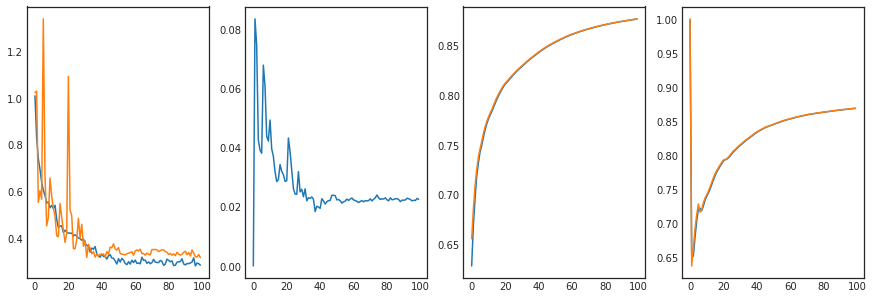

In [20]:
fig, (ax_loss, ax_temp_loss, ax_acc, ax_iou) = plt.subplots(1,4, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_temp_loss.plot(history.epoch, history.history["temperal_mse_loss"], label="Train loss")
# ax_temp_loss.plot(history.epoch, history.history["val_temperal_mse_loss"], label="Validation loss")
ax_acc.plot(history.epoch, history.history["mask_mean_iou"], label="Train mask iou")
ax_acc.plot(history.epoch, history.history["val_mask_mean_iou"], label="Validation mask iou")
ax_iou.plot(history.epoch, history.history["temperal_mean_iou"], label="Train temperal iou")
ax_iou.plot(history.epoch, history.history["val_temperal_mean_iou"], label="Validation temperal iou")

# Fine tune threshold

In [21]:
# model = load_model("./model-unet-resnet.h5", custom_objects={'mean_iou':mean_iou})

# # used for predict, no dropout
temperal = Temperal_Callback()
model_predict = UNet((img_size_target,img_size_target,1),start_ch=16,depth=5,batchnorm=True, dropout=0.0, training=False)
model_predict.compile(loss=temperal.temporal_loss, optimizer="adam", metrics=[masked_crossentropy, temperal_mse_loss, mask_mean_iou, temperal_mean_iou])
model_predict.set_weights(model_train.get_weights())

X_valid = np.expand_dims(np.stack((np.asarray(val_df['img'].values.tolist()))),axis=3)
y_valid = np.expand_dims(np.asarray(val_df['img_mask'].values.tolist()),axis=3)
preds_valid = model_predict.predict(X_valid, batch_size=32, verbose=1)

400/400 [==============================] - 2s 4ms/step


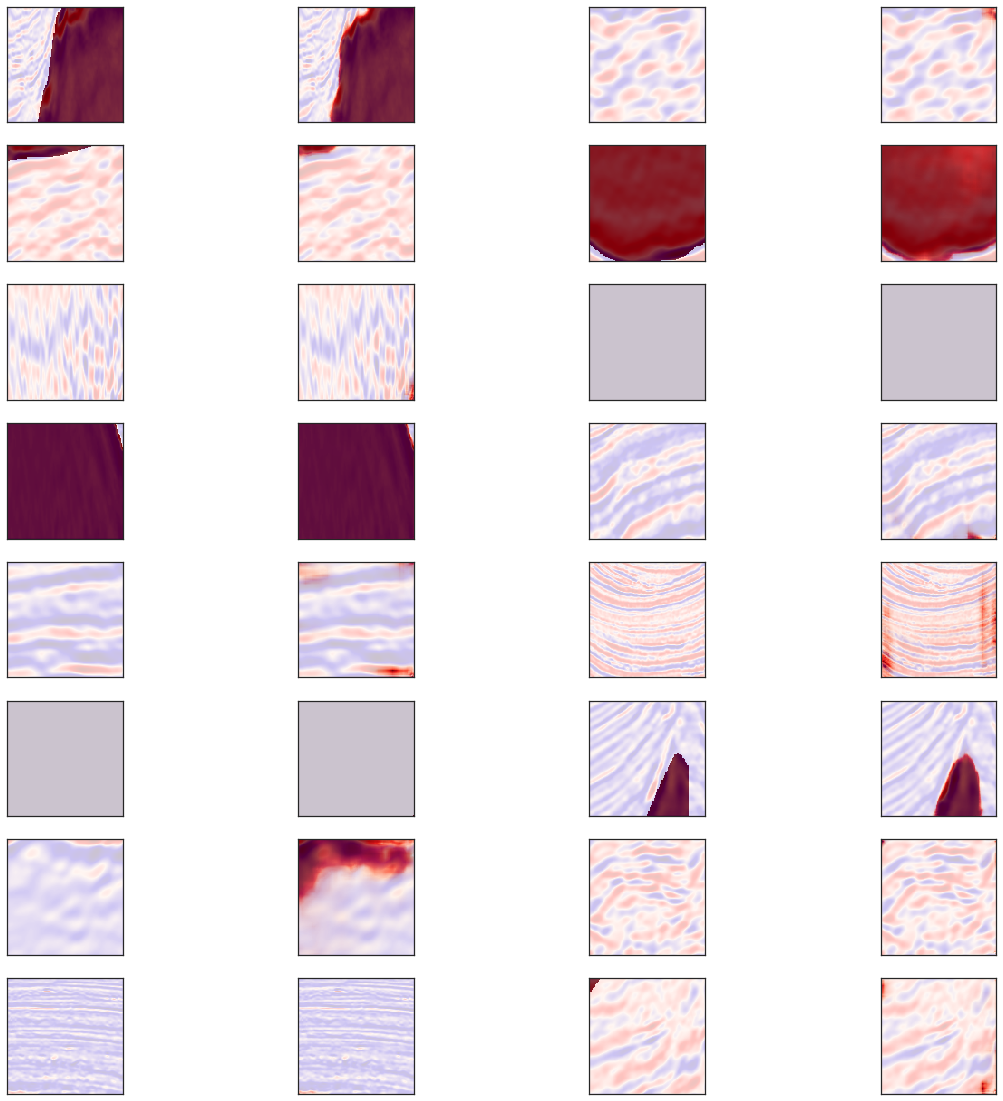

In [22]:
# plot some validate result
base_idx = 10
max_images = 32
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))
row = 0; col = 0;
for i, idx in enumerate(val_df.index[base_idx:base_idx+int(max_images/2)]):
    img = val_df.iloc[i].img
    mask = val_df.iloc[i].img_mask
    pred = preds_valid[i].squeeze()
    
    ax = axs[row, col];
    ax.imshow(img, cmap="seismic")
    ax.imshow(mask, alpha=0.8, cmap="Reds"); col+=1;
    ax.set_yticklabels([]); ax.set_xticklabels([]);
    
    ax = axs[row, col];
    ax.imshow(img, cmap="seismic")
    ax.imshow(pred, alpha=0.8, cmap="Reds"); col+=1;
    ax.set_yticklabels([]);ax.set_xticklabels([]);
    
    if col >= grid_width:
        col=0; row+=1;


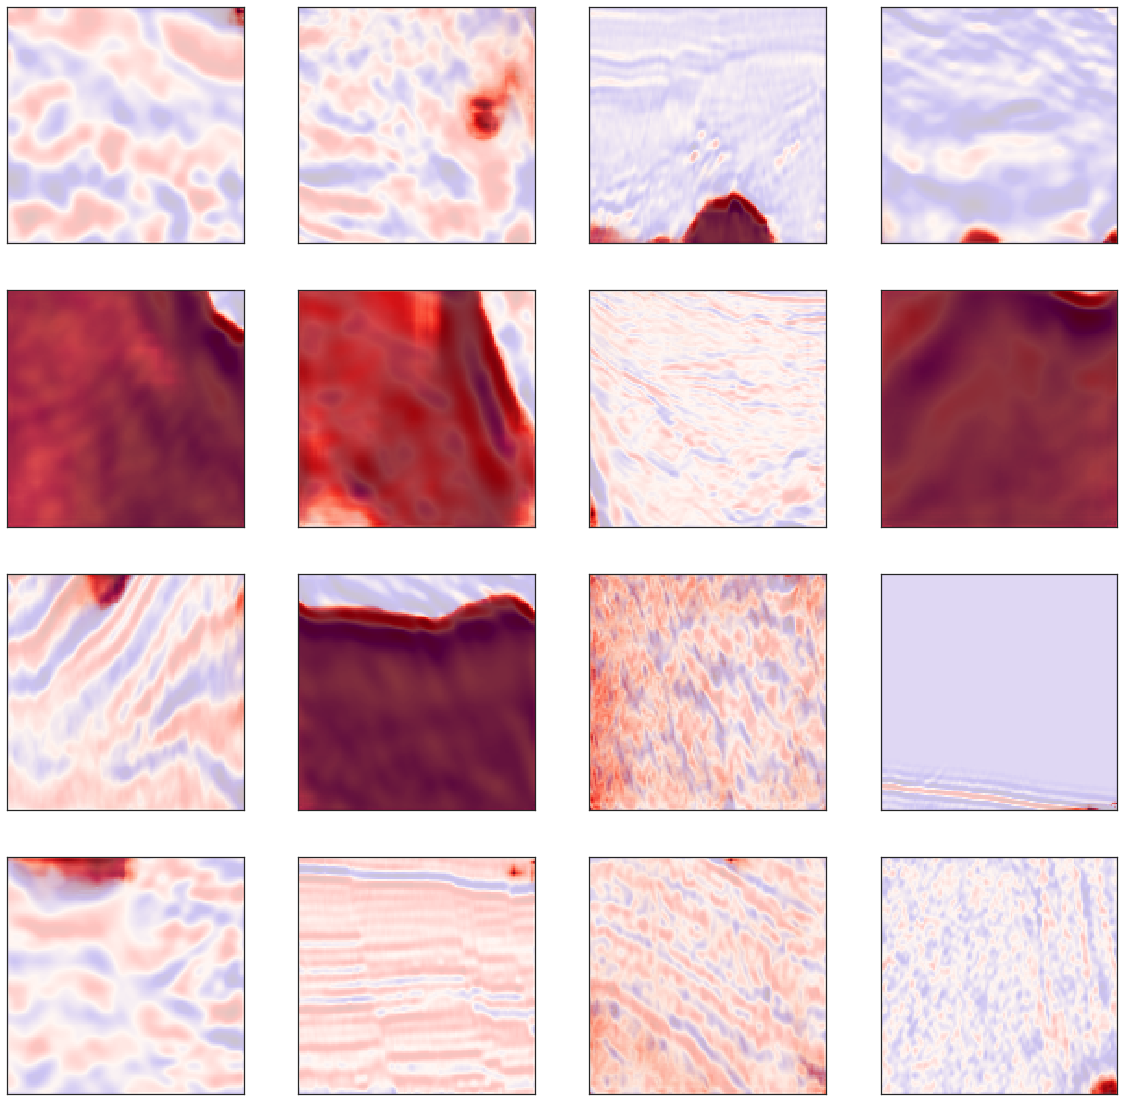

In [23]:
# plot some temperal mask on test results
base_idx = 0
max_images = 16
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))
row = 0; col = 0;
for i, idx in enumerate(test_df.index[base_idx:base_idx+int(max_images)]):
    img = test_df.loc[idx].img
    mask = test_df.loc[idx].img_temperal_mask
    
    ax = axs[row, col];
    ax.imshow(img, cmap="seismic")
#     ax.imshow(img, cmap="gray")
    ax.imshow(mask, alpha=0.8, cmap="Reds"); col+=1;
    ax.set_yticklabels([]); ax.set_xticklabels([]);
    
    if col >= grid_width:
        col=0; row+=1;


In [24]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch],print_table=False)
        metric.append(value)
    return np.mean(metric)


from math import sqrt
from joblib import Parallel, delayed
import multiprocessing  
from tqdm import tqdm  

thresholds = np.linspace(0, 1, 20)
# result = Parallel(n_jobs=2)(io_metric_batch(train_y, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds))
# ious = np.array([iou_metric_batch(train_y, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])
ious = np.array([iou_metric_batch(y_valid, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])

threshold_best: 0.7368421052631579, iou_best: 0.7635


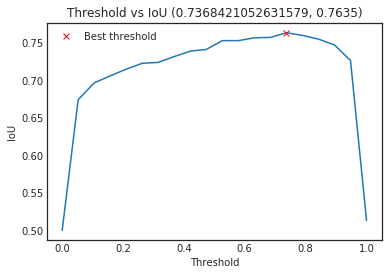

In [25]:
threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

print(f'threshold_best: {threshold_best}, iou_best: {iou_best}')

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

# Predict test data

In [26]:
img_size_ori = 101
img_size_target = 128

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]
    
# Source https://www.kaggle.com/bguberfain/unet-with-depth
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [27]:
X_test = np.expand_dims(np.stack((np.asarray(test_df['img'].values.tolist()))),axis=3)
preds_test = model_predict.predict(X_test, batch_size=32, verbose=1)
final_preds_test = preds_test > threshold_best

18000/18000 [==============================] - 34s 2ms/step


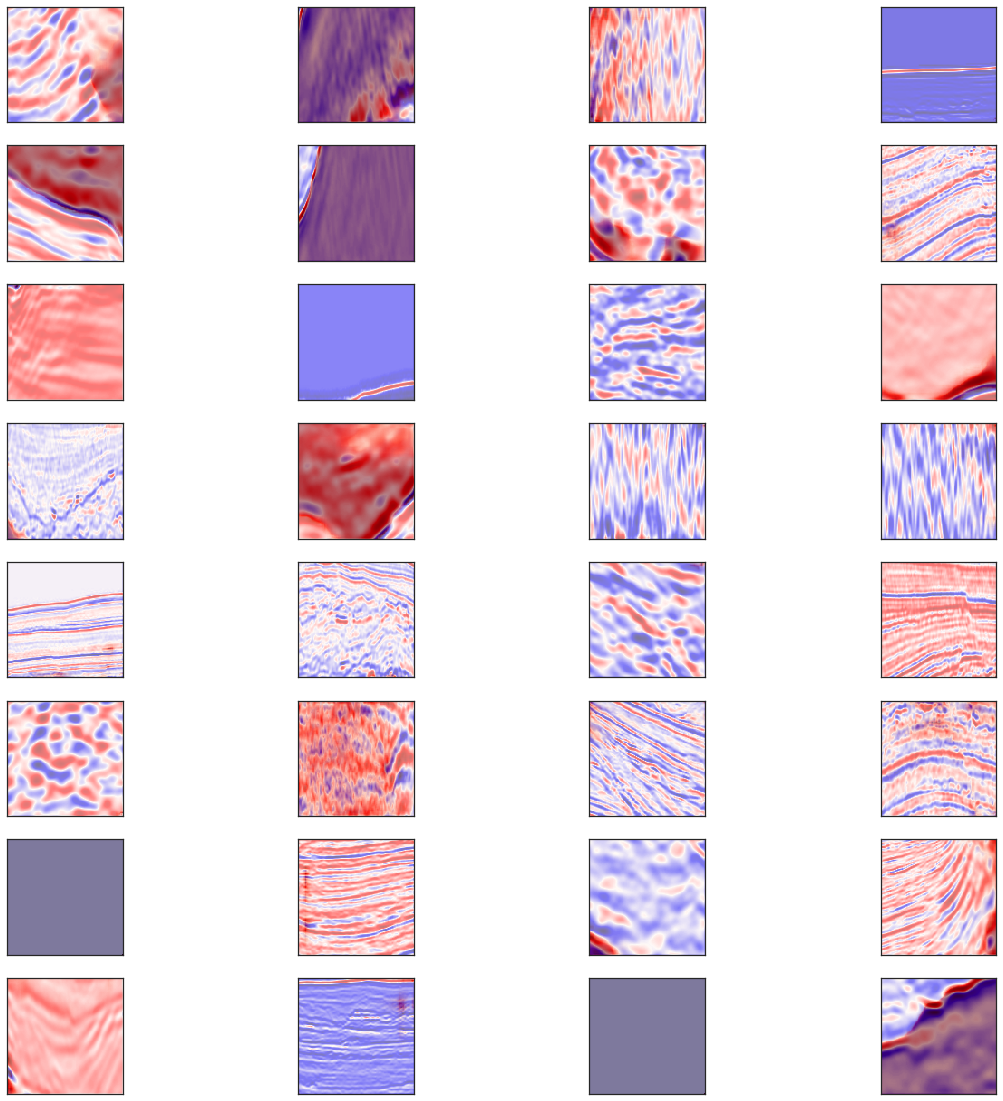

In [28]:
base_idx = 160
max_images = 32
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))
row = 0; col = 0;
for i in range(base_idx,base_idx+int(max_images)):
    img = X_test[i].squeeze()
    mask = preds_test[i].squeeze()
    
    ax = axs[row, col];
    ax.imshow(img, cmap="seismic")
    ax.imshow(mask, alpha=0.5, cmap="Reds"); col+=1;
    ax.set_yticklabels([]); ax.set_xticklabels([]);
    
    if col >= grid_width:
        col=0; row+=1;

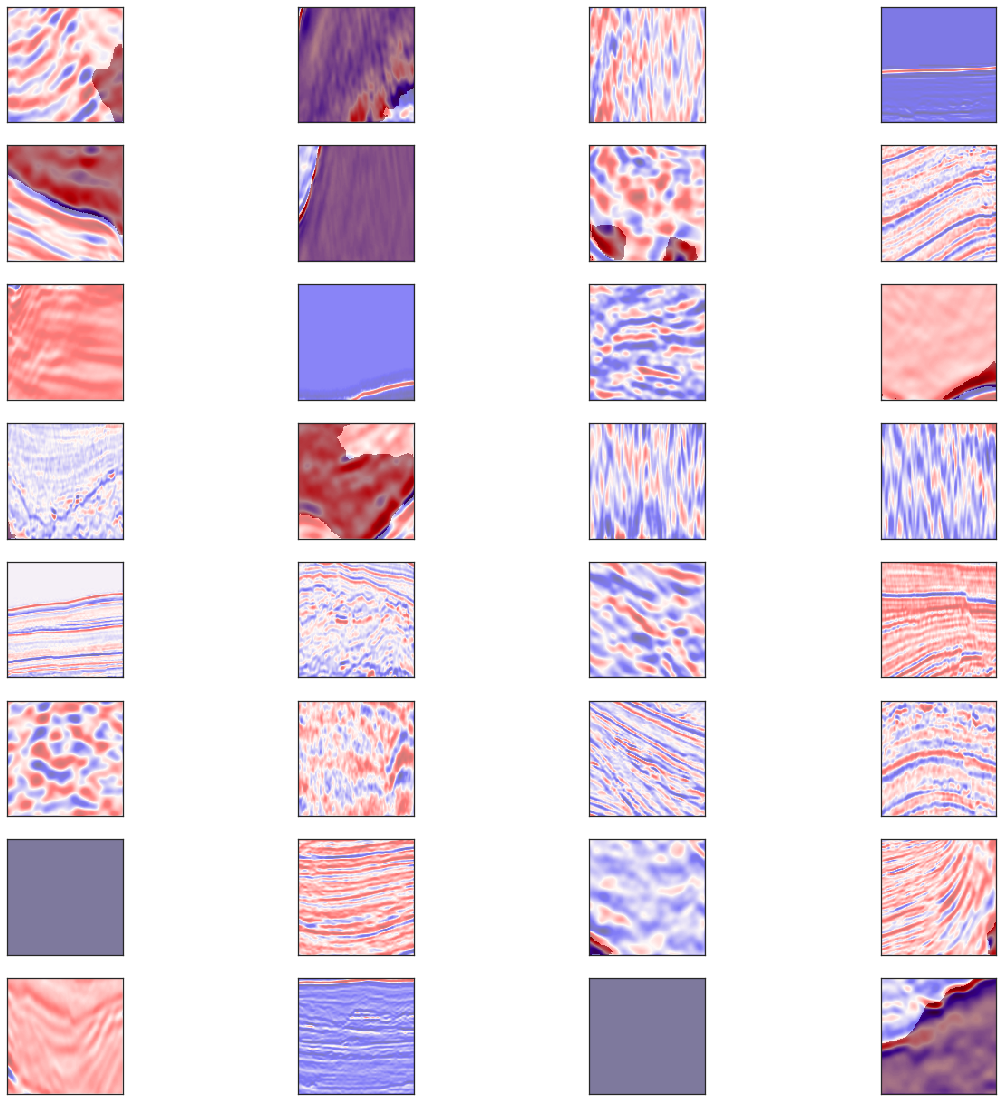

In [29]:
base_idx = 160
max_images = 32
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))
row = 0; col = 0;
for i in range(base_idx,base_idx+int(max_images)):
    img = X_test[i].squeeze()
    mask = final_preds_test[i].squeeze()
    
    ax = axs[row, col];
    ax.imshow(img, cmap="seismic")
    ax.imshow(mask, alpha=0.5, cmap="Reds"); col+=1;
    ax.set_yticklabels([]); ax.set_xticklabels([]);
    
    if col >= grid_width:
        col=0; row+=1;

# Apply CRF

In [30]:
#Original_image = Image which has to labelled
#Mask image = Which has been labelled by some technique..
def crf(original_image, mask_img):
    
    # Converting annotated image to RGB if it is Gray scale
    if(len(mask_img.shape)<3):
        mask_img = gray2rgb(mask_img)

#     #Converting the annotations RGB color to single 32 bit integer
    annotated_label = mask_img[:,:,0] + (mask_img[:,:,1]<<8) + (mask_img[:,:,2]<<16)
    
#     # Convert the 32bit integer color to 0,1, 2, ... labels.
    colors, labels = np.unique(annotated_label, return_inverse=True)

    n_labels = 2
    
    #Setting up the CRF model
    d = dcrf.DenseCRF2D(original_image.shape[1], original_image.shape[0], n_labels)

    # get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=False)
    d.setUnaryEnergy(U)

    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL,
                      normalization=dcrf.NORMALIZE_SYMMETRIC)
        
    #Run Inference for 10 steps 
    Q = d.inference(10)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    return MAP.reshape((original_image.shape[0],original_image.shape[1]))

In [31]:
"""
Applying CRF on the predicted mask 

"""
crf_output = []
for i in tqdm(range(X_test.shape[0])):
    crf_output.append(crf(np.squeeze(X_test[i]),np.squeeze(final_preds_test[i])))

100%|██████████| 18000/18000 [07:20<00:00, 40.84it/s]


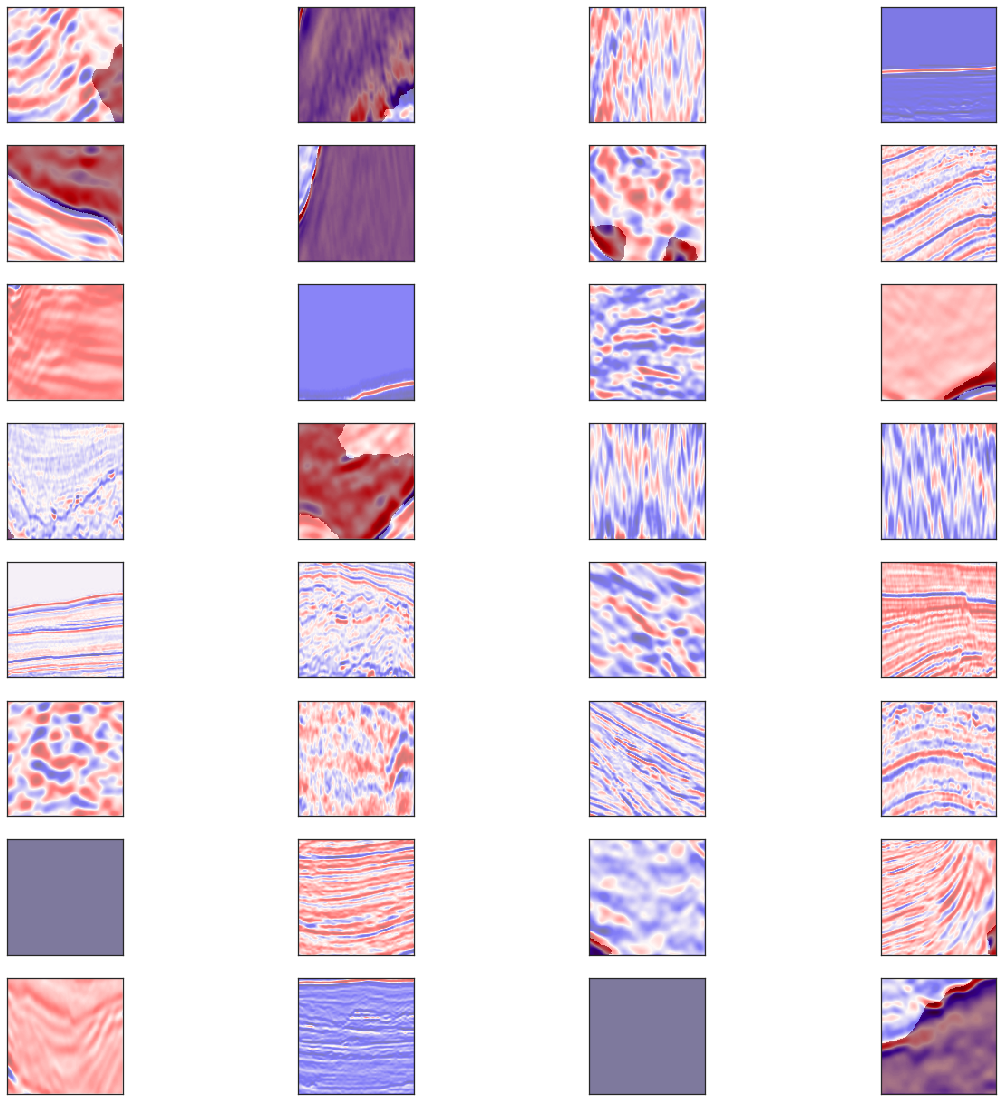

In [32]:
base_idx = 160
max_images = 32
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))
row = 0; col = 0;
for i in range(base_idx,base_idx+int(max_images)):
    img = X_test[i].squeeze()
    mask = crf_output[i].squeeze()
    
    ax = axs[row, col];
    ax.imshow(img, cmap="seismic")
    ax.imshow(mask, alpha=0.5, cmap="Reds"); col+=1;
    ax.set_yticklabels([]); ax.set_xticklabels([]);
    
    if col >= grid_width:
        col=0; row+=1;

In [33]:
threshold_best=threshold_best
pred_dict = {idx: RLenc(np.round(downsample(crf_output[i]))) for i, idx in enumerate(tqdm_notebook(test_df.img_id.values))}
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission_pinet_crf.csv')